<div style="text-align: center;"> <h1> FURIA Know Your Fan (Análise Geral) </h1> </div>

### Configurações Iniciais

#### Importação Chave API (Arquivo .env)

### Coleta de Dados

##### Comentários YTB - JSON (Link)

In [ ]:
import os
import json
from googleapiclient.discovery import build
from dotenv import load_dotenv
from pathlib import Path

env_path = Path('.idea/.env')  # ex: Path('config/.env')
load_dotenv(dotenv_path=env_path)

# Testa se a chave da API está sendo carregada
api_key = os.getenv("YOUTUBE_API_KEY")


# ID do vídeo do qual você quer obter os comentários
video_id = '8aIcU-_5W34'


def get_video_channel_name(video_id, api_key):
    # Conectando à API do YouTube
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    # Obtém as informações do vídeo
    request = youtube.videos().list(
        part='snippet',
        id=video_id
    )
    
    # Realiza a requisição e pega o nome do canal
    response = request.execute()
    if response['items']:
        channel_name = response['items'][0]['snippet']['channelTitle']
        return channel_name
    return None

# Função para obter comentários do vídeo
def get_comments(video_id, api_key):
    # Conectando à API do YouTube
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    # Lista para armazenar os comentários
    comments = []
    
    channel_name = get_video_channel_name(video_id, api_key)
    
    # Inicializa a requisição para obter os comentários
    request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        textFormat='plainText',
        maxResults=100  # Max resultados por requisição (pode ajustar conforme necessário)
    )
    
    # Realiza a requisição
    while request:
        response = request.execute()
        
        # Itera sobre os comentários e armazena os dados
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comment_data = {
                    'video_id': video_id,                    # ← aqui você adiciona o ID do vídeo
                    'author': comment['authorDisplayName'],
                    'text': comment['textDisplay'],
                    'published_at': comment['publishedAt'],
                    'likes': comment['likeCount'],
                    'channel_name': channel_name
                }
            
            comments.append(comment_data)
        
        # Verifica se existe uma próxima página de resultados
        request = youtube.commentThreads().list_next(request, response)
    
    return comments

# Obter os comentários
# Função para salvar os comentários sem sobrescrever o arquivo existente
def save_comments(comments, filename='comentarios_video.json'):
    # Caminho da pasta onde você deseja salvar o arquivo
    pasta = 'form_data'

    # Certifique-se de que a pasta existe
    if not os.path.exists(pasta):
        os.makedirs(pasta)

    # Caminho completo do arquivo JSON
    arquivo_json = os.path.join(pasta, filename)
    
    # Verifica se o arquivo já existe
    if os.path.exists(arquivo_json):
        # Carrega o conteúdo existente
        with open(arquivo_json, 'r', encoding='utf-8') as f:
            existing_comments = json.load(f)
        
        # Adiciona os novos comentários ao conteúdo existente
        existing_comments.extend(comments)
        
        # Salva o conteúdo atualizado
        with open(arquivo_json, 'w', encoding='utf-8') as f:
            json.dump(existing_comments, f, indent=4, ensure_ascii=False)
    else:
        # Caso o arquivo não exista, cria um novo com os comentários
        with open(arquivo_json, 'w', encoding='utf-8') as f:
            json.dump(comments, f, indent=4, ensure_ascii=False)

# Obter os comentários
comments = get_comments(video_id, api_key)

# Salvar os comentários sem sobrescrever o arquivo
save_comments(comments)

print("Comentários salvos em 'form_data/comentarios_video.json'")

#### Comentários YTB - JSON - GUI (Custom Tkinter)

In [ ]:
%pip install customtkinter google-api-python-client python-dotenv

In [1]:
import os
import json
import customtkinter as ctk
from googleapiclient.discovery import build
from dotenv import load_dotenv
from pathlib import Path
import re
import tkinter.messagebox as msgbox

# Load .env
env_path = Path('.idea/.env')  # Ajuste conforme necessário
load_dotenv(dotenv_path=env_path)
api_key = os.getenv("YOUTUBE_API_KEY")

# Detecta ID do vídeo
def extract_video_id(url):
    match = re.search(r"(?:v=|youtu\.be/)([a-zA-Z0-9_-]{11})", url)
    return match.group(1) if match else None

# Detecta ID da playlist
def extract_playlist_id(url):
    match = re.search(r"[?&]list=([a-zA-Z0-9_-]+)", url)
    return match.group(1) if match else None

# Pega nome do canal
def get_video_channel_name(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    request = youtube.videos().list(part='snippet', id=video_id)
    response = request.execute()
    if response['items']:
        return response['items'][0]['snippet']['channelTitle']
    return None

# Busca comentários
def get_comments(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    channel_name = get_video_channel_name(video_id)
    request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        textFormat='plainText',
        maxResults=100
    )
    while request:
        response = request.execute()
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comment_data = {
                'video_id': video_id,
                'author': comment['authorDisplayName'],
                'text': comment['textDisplay'],
                'published_at': comment['publishedAt'],
                'likes': comment['likeCount'],
                'channel_name': channel_name
            }
            comments.append(comment_data)
        request = youtube.commentThreads().list_next(request, response)
    return comments

# Salva no JSON
def save_comments(comments, filename='comentarios_video.json'):
    pasta = 'form_data'
    os.makedirs(pasta, exist_ok=True)
    caminho = os.path.join(pasta, filename)
    if os.path.exists(caminho):
        with open(caminho, 'r', encoding='utf-8') as f:
            existentes = json.load(f)
        existentes.extend(comments)
        with open(caminho, 'w', encoding='utf-8') as f:
            json.dump(existentes, f, indent=4, ensure_ascii=False)
    else:
        with open(caminho, 'w', encoding='utf-8') as f:
            json.dump(comments, f, indent=4, ensure_ascii=False)

# Busca vídeos de uma playlist
def get_video_ids_from_playlist(playlist_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    video_ids = []
    request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlist_id,
        maxResults=50
    )
    while request:
        response = request.execute()
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        request = youtube.playlistItems().list_next(request, response)
    return video_ids

# Processa link inserido
def process_link():
    url = entry_url.get().strip()
    if not url:
        status_label.configure(text="Cole um link válido do YouTube.", text_color="red")
        return

    playlist_id = extract_playlist_id(url)
    video_id = extract_video_id(url)

    if playlist_id:
        try:
            video_ids = get_video_ids_from_playlist(playlist_id)
            total_comments = []
            for vid in video_ids:
                status_label.configure(text=f"Buscando comentários de {vid}...", text_color="blue")
                comments = get_comments(vid)
                total_comments.extend(comments)
            save_comments(total_comments)
            status_label.configure(text=f"Todos os comentários da playlist foram salvos!", text_color="green")
        except Exception as e:
            status_label.configure(text=f"Erro: {e}", text_color="red")
            return

    elif video_id:
        try:
            status_label.configure(text="Buscando comentários do vídeo...", text_color="blue")
            comments = get_comments(video_id)
            save_comments(comments)
            status_label.configure(text=f"Comentários do vídeo foram salvos!", text_color="green")
        except Exception as e:
            status_label.configure(text=f"Erro: {e}", text_color="red")
            return
    else:
        status_label.configure(text="Link inválido. Verifique se é um link do YouTube.", text_color="red")
        return

    # Pergunta se deseja adicionar mais
    continuar = msgbox.askyesno("Continuar", "Deseja adicionar outro vídeo ou playlist?")
    if continuar:
        entry_url.delete(0, 'end')
        status_label.configure(text="Cole outro link para continuar.", text_color="black")
    else:
        app.quit()
        app.destroy()

# GUI com customtkinter
ctk.set_appearance_mode("System")
ctk.set_default_color_theme("blue")

app = ctk.CTk()
app.title("Coletor de Comentários YouTube")
app.geometry("600x300")

label = ctk.CTkLabel(app, text="Cole o link do vídeo ou playlist do YouTube:")
label.pack(pady=10)

entry_url = ctk.CTkEntry(app, width=500)
entry_url.pack(pady=10)

submit_button = ctk.CTkButton(app, text="Buscar e Salvar Comentários", command=process_link)
submit_button.pack(pady=20)

status_label = ctk.CTkLabel(app, text="")
status_label.pack(pady=10)

app.mainloop()


#### Comentários - JSON (Twitter/X)

In [ ]:
import tweepy
import json
import os
from dotenv import load_dotenv
from pathlib import Path

env_path = Path('.idea/.env')  # ex: Path('config/.env')
load_dotenv(dotenv_path=env_path)

chave_api = os.getenv("twitter_api")

# ————————— Configurações e autenticação —————————
BEARER_TOKEN = chave_api  # Substitua pelo seu Bearer Token

client = tweepy.Client(bearer_token=BEARER_TOKEN)

# Parâmetros de pesquisa com a hashtag #DIADEFURIA incluída
query = '(Fallen OR KSCERATO OR yuurih OR molodoy OR skullz OR chelo OR fNb OR Goot OR Envy OR Trigo OR RedBert OR Fntzy OR R4re OR Handyy OR KDS OR yanxnz OR Lostt OR nzr OR Khalil OR havoc OR xand OR mwzera OR Xeratricky OR Pandxrz OR HisWattson OR #FURIACS OR #FURIAR6 OR #FURIAFC OR #DIADEFURIA) -is:retweet lang:pt'
max_results = 10

# Fazendo a busca com os campos desejados
tweets = client.search_recent_tweets(query=query, max_results=max_results,
                                     tweet_fields=["author_id", "conversation_id", "created_at", "geo", "id", "lang", "source", "text"],
                                     user_fields=["created_at", "description", "entities", "id", "location", "name", "url", "username"],
                                     expansions=["author_id"])

# Convertendo os tweets para um formato de dicionário
tweets_data = []
if tweets.data:
    for tweet in tweets.data:
        tweet_info = {
            'tweet_id': tweet.id,
            'text': tweet.text,
            'created_at': str(tweet.created_at),
            'author_id': tweet.author_id,
            'conversation_id': tweet.conversation_id,
            'geo': tweet.geo,
            'lang': tweet.lang,
            'source': tweet.source
        }

        # Obtendo informações do usuário (quem postou o tweet)
        if tweets.includes and 'users' in tweets.includes:
            for user in tweets.includes['users']:
                if user.id == tweet.author_id:
                    tweet_info['user'] = {
                        'created_at': str(user.created_at),
                        'description': user.description,
                        'entities': user.entities,
                        'location': user.location,
                        'name': user.name,
                        'url': user.url,
                        'username': user.username
                    }
                    break

        tweets_data.append(tweet_info)

# Caminho da pasta onde você deseja salvar o arquivo
pasta = 'form_data'

# Certifique-se de que a pasta existe
if not os.path.exists(pasta):
    os.makedirs(pasta)

# Caminho completo do arquivo JSON
arquivo_json = os.path.join(pasta, 'tweetsGerais_furia.json')

# Carrega o conteúdo existente, se houver
if os.path.exists(arquivo_json):
    with open(arquivo_json, 'r', encoding='utf-8') as f:
        dados_existentes = json.load(f)
else:
    dados_existentes = []

# Adiciona os novos tweets
dados_existentes.extend(tweets_data)

# Salva de volta no JSON
with open(arquivo_json, 'w', encoding='utf-8') as f:
    json.dump(dados_existentes, f, ensure_ascii=False, indent=4)

print("Tweets adicionados com sucesso a 'tweets_furia.json'.")

Tweets adicionados com sucesso a 'tweetsGerais_furia.json'.


#### Posts - JSON (Reddit)

In [2]:
import requests
import json
import os

query = "FURIA OR Fallen OR KSCERATO OR yuurih OR molodoy OR skullz OR chelo OR fNb OR Goot OR Envy OR RedBert OR Fntzy OR R4re OR Handyy OR KDS OR yanxnz OR Lostt OR nzr OR Khalil OR havoc OR xand OR mwzera OR Xeratricky OR Pandxrz OR HisWattson"

subreddits = ["GlobalOffensive", "csgo", "VALORANT", "cs2", "cblol", "LolEsports", "ValorantCompetitive", "VCT", "R6ProLeague"]
limit = 50

resultados = []

# Loop pelos subreddits
for subreddit in subreddits:
    url = f"https://www.reddit.com/r/{subreddit}/search.json?q={query}&restrict_sr=on&limit={limit}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response = requests.get(url, headers=headers)
    data = response.json()

    if "data" in data and "children" in data["data"]:
        for post in data["data"]["children"]:
            p = post["data"]

            # Verifica se a query aparece no título ou no texto do post
            titulo = p.get("title", "")
            texto = p.get("selftext", "")

            # Verificação literal, sem usar lower()
            if any(jogador in titulo or jogador in texto for jogador in query.split(" OR ")):
                resultados.append({
                    "titulo": p.get("title"),
                    "autor": p.get("author"),
                    "subreddit": subreddit,
                    "score": p.get("score", 0),
                    "url": "https://reddit.com" + p.get("permalink"),
                    "data_criacao": p.get("created_utc"),
                    "comentario_exemplo": p.get("selftext", "")
                })

# Caminho da pasta onde você deseja salvar o arquivo
pasta = 'form_data'

# Certifique-se de que a pasta existe
if not os.path.exists(pasta):
    os.makedirs(pasta)

# Caminho completo do arquivo JSON
arquivo_json = os.path.join(pasta, "posts_furia_reddit.json")

# Salva em JSON
# Verifica se o arquivo já existe e carrega os dados antigos
if os.path.exists(arquivo_json):
    with open(arquivo_json, "r", encoding="utf-8") as f:
        dados_existentes = json.load(f)
else:
    dados_existentes = []

# Junta os dados antigos com os novos
dados_atuaisizados = dados_existentes + resultados

# Salva todos os dados no JSON
with open(arquivo_json, "w", encoding="utf-8") as f:
    json.dump(dados_atuaisizados, f, indent=4, ensure_ascii=False)
    print("Novos dados adicionados ao JSON.")



Novos dados adicionados ao JSON.


<div style="text-align: center;"> <h3>Enriquecimento de Perfil com Dados Sociais e Multimídia</h3> </div>

- **Análise de Comentários:** Para integrar comentários prévios do usuário no YouTube, Reddit e Twitter, incluir blocos que consumam APIs ou dados locais de análise anterior (supondo que existam). Usar `google-api-python-client` para extrair comentários de vídeos de e-sports do YouTube, `PRAW` para posts/comentários no Reddit, e `tweepy` ou dados simulados para tweets.  
- **Processamento de Linguagem Natural:** Aplicar NLP para entender o perfil do usuário: usar bibliotecas como `transformers` ou `spaCy` para classificar sentimento, identificar tópicos ou palavras-chave frequentes nesses comentários. Por exemplo, gerar um gráfico de palavras-chave mais mencionadas em e-sports, ou uma análise de sentimento geral sobre jogos específicos.  
- **Integração de Informações:** Combinar esses insights com os interesses declarados pelo usuário. Exibir visualmente (via `matplotlib` ou `seaborn`) uma nuvem de palavras ou gráfico que mostre as categorias de e-sports mais relevantes para o perfil (baseado em interesses + análise de comentários).  
- **Perfis em Sites de e-Sports:** Permitir que o usuário insira links para seus perfis em plataformas de e-sports (como GameBattles, HLTV, Liquipedia). Usar `requests` e `BeautifulSoup` para raspar detalhes do perfil (jogos, histórico de partidas). Em seguida, aplicar um modelo de IA (ex: `transformers` BERT) para classificar se o conteúdo textual do perfil é relevante às preferências do usuário (por exemplo, buscando termos de jogos citados pelo usuário). Mostrar se há “match” entre interesses do usuário e informações do perfil scraped.  

### Análise de Dados e Visualização Detalhada

#### Análise Geral (Youtube)

In [ ]:
%pip install pandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json(R'form_data\comentarios_video.json')

Remoção de Duplicatas

In [ ]:
df_unico = df.drop_duplicates(subset=["text", "author"])

# Salva o DataFrame limpo de volta no JSON
df_unico.to_json(R"form_data\comentarios_video.json", orient="records", indent=4, force_ascii=False)

print(f"Removidas {len(df) - len(df_unico)} duplicatas.")

In [ ]:
# 2. Converte published_at (ISO 8601) para datetime do pandas
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)

# 3. Extrai colunas de data e hora para facilitar agregações
df['data'] = df['published_at'].dt.date
df['hora'] = df['published_at'].dt.time

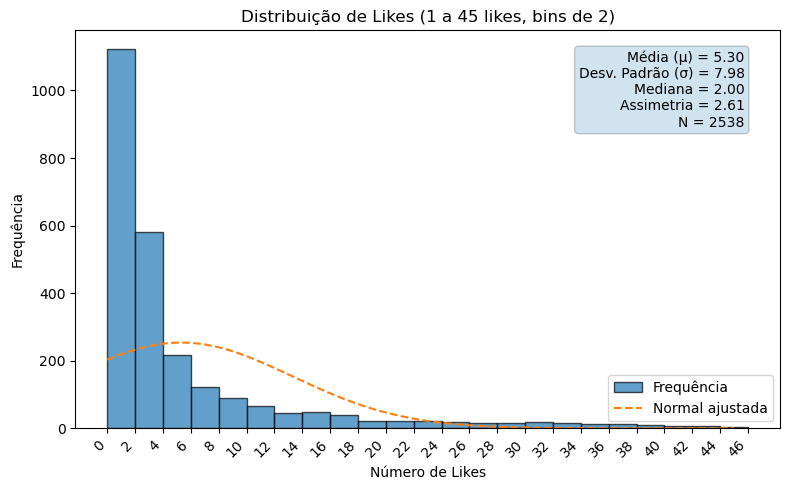

5469 comentários removidos (0 ou >45 likes)
Estatísticas dos comentários mantidos:
Média (μ) = 5.30
Desv. Padrão (σ) = 7.98
Mediana = 2.00
Assimetria = 2.61
N = 2538


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Carrega o JSON em DataFrame
df = pd.read_json('form_data/comentarios_video.json')

# 2. Separa comentários válidos (1 a 45 likes) e calcula estatísticas
df_filtrado = df[(df['likes'] > 0) & (df['likes'] <= 45)]
# Extrai série de likes após filtragem
n_likes = df_filtrado['likes']
# Estatísticas descritivas
mu = n_likes.mean()
sigma = n_likes.std(ddof=0)
median = n_likes.median()
skewness = n_likes.skew()

# 3. Configura histograma e sobrepõe curva Normal ajustada
bin_edges = np.arange(0, 47, 2)
bin_width = bin_edges[1] - bin_edges[0]
counts, bins = np.histogram(n_likes, bins=bin_edges)

plt.figure(figsize=(8, 5))
# histograma
plt.hist(n_likes, bins=bin_edges, edgecolor='black', alpha=0.7, label='Frequência')
# curva Normal ajustada (densidade * escala)
x = np.linspace(0, 45, 500)
pdf = norm.pdf(x, mu, sigma) * len(n_likes) * bin_width
plt.plot(x, pdf, linestyle='--', label='Normal ajustada')

# 4. Anotações de estatísticas
stats_text = (
    f'Média (μ) = {mu:.2f}\n'
    f'Desv. Padrão (σ) = {sigma:.2f}\n'
    f'Mediana = {median:.2f}\n'
    f'Assimetria = {skewness:.2f}\n'
    f'N = {len(n_likes)}'
)
plt.gca().text(
    0.95, 0.95, stats_text,
    transform=plt.gca().transAxes,
    verticalalignment='top', horizontalalignment='right',
    fontsize='10', bbox=dict(boxstyle='round', alpha=0.2)
)

# 5. Ajustes visuais
ticks = bin_edges
labels = [str(int(b)) for b in bin_edges]
plt.xticks(ticks=ticks, labels=labels, rotation=45, ha='right')
plt.title('Distribuição de Likes (1 a 45 likes, bins de 2)')
plt.xlabel('Número de Likes')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Exibe resumo de removidos e estatísticas
removed = df.shape[0] - df_filtrado.shape[0]
print(f"{removed} comentários removidos (0 ou >45 likes)")
print(f"Estatísticas dos comentários mantidos:\n{stats_text}")

# 7. Estrutura dos resultados para distribuição de likes
resultados_distribuicao = {
    "total_comentarios": int(df.shape[0]),
    "comentarios_mantidos": int(len(n_likes)),
    "comentarios_removidos": int(removed),
    "estatisticas": {
        "media": round(mu, 2),
        "desvio_padrao": round(sigma, 2),
        "mediana": round(median, 2),
        "assimetria": round(skewness, 2)
    }
}

# 8. Diretório e arquivo de saída
pasta_resultados = 'analysis_results'
arquivo_resultados = os.path.join(pasta_resultados, 'analise_ytb.json')

# 9. Cria a pasta se não existir
os.makedirs(pasta_resultados, exist_ok=True)

# 10. Cria o arquivo se não existir
if not os.path.exists(arquivo_resultados):
    with open(arquivo_resultados, 'w', encoding='utf-8') as f:
        json.dump({}, f, ensure_ascii=False, indent=4)

# 11. Carrega o conteúdo atual do JSON
with open(arquivo_resultados, 'r', encoding='utf-8') as f:
    todos_resultados = json.load(f)

# 12. Atualiza os dados da análise de distribuição de likes
todos_resultados["distribuicao_likes"] = resultados_distribuicao

# 13. Salva o JSON final com a nova análise
with open(arquivo_resultados, 'w', encoding='utf-8') as f:
    json.dump(todos_resultados, f, ensure_ascii=False, indent=4)


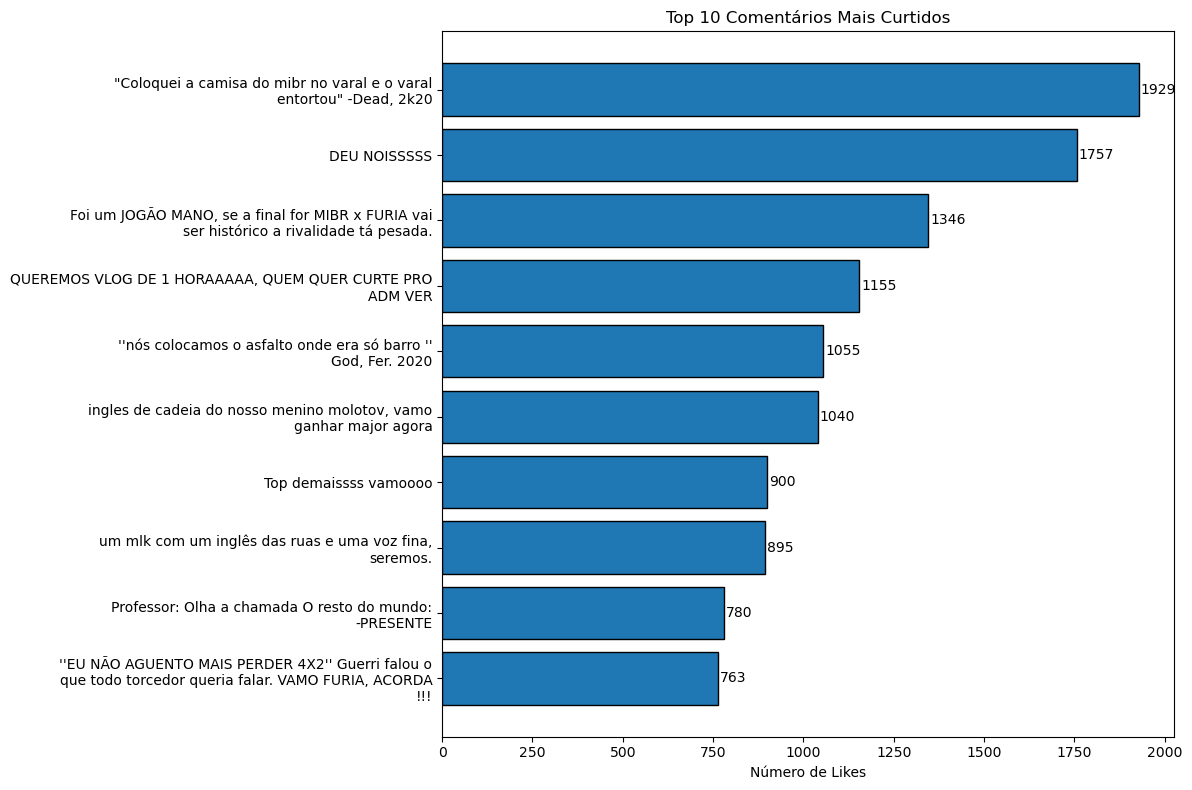

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# 1. Carrega o JSON em DataFrame
df = pd.read_json('form_data/comentarios_video.json')

# 2. Ordena pelo número de likes e pega os top N (ajuste N se quiser mais/menos)
N = 10
top_comments = df.sort_values('likes', ascending=False).head(N)

# 3. Prepara os rótulos: quebra linhas para caber melhor no gráfico
wrapped_texts = [
    textwrap.fill(text, width=50)
    for text in top_comments['text']
]

# 4. Plota gráfico de barras horizontais com o texto do comentário
plt.figure(figsize=(12, 8))
plt.barh(range(N), top_comments['likes'], edgecolor='black')
plt.yticks(range(N), wrapped_texts)
plt.xlabel('Número de Likes')
plt.title(f'Top {N} Comentários Mais Curtidos')
plt.gca().invert_yaxis()  # Inverte o eixo para o comentário mais curtido ficar no topo

# 5. Anotações com o número exato de likes ao final de cada barra
for i, like in enumerate(top_comments['likes']):
    plt.text(like + 5, i, str(like), va='center')

plt.tight_layout()
plt.show()

# 6. Estrutura de resultados para salvar no JSON
top_comentarios_data = [
    {
        "texto": row['text'],
        "likes": int(row['likes'])
    }
    for _, row in top_comments.iterrows()
]

# 7. Diretório e arquivo JSON
pasta_resultados = 'analysis_results'
arquivo_resultados = os.path.join(pasta_resultados, 'analise_ytb.json')

# 8. Garante que a pasta existe
os.makedirs(pasta_resultados, exist_ok=True)

# 9. Cria o arquivo se não existir
if not os.path.exists(arquivo_resultados):
    with open(arquivo_resultados, 'w', encoding='utf-8') as f:
        json.dump({}, f, ensure_ascii=False, indent=4)

# 10. Carrega JSON existente
with open(arquivo_resultados, 'r', encoding='utf-8') as f:
    todos_resultados = json.load(f)

# 11. Atualiza os dados
todos_resultados["top_10_comentarios"] = top_comentarios_data

# 12. Salva novamente
with open(arquivo_resultados, 'w', encoding='utf-8') as f:
    json.dump(todos_resultados, f, ensure_ascii=False, indent=4)


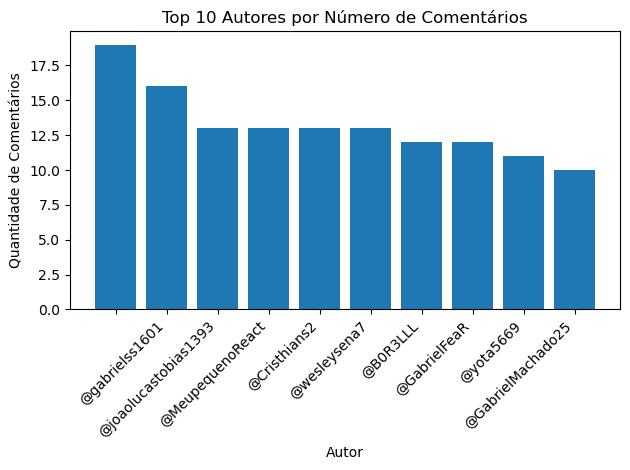

In [5]:
# Top 10 autores por número de comentários
top_autores = df['author'].value_counts().head(10)
plt.figure()
plt.bar(top_autores.index, top_autores.values)
plt.title('Top 10 Autores por Número de Comentários')
plt.xlabel('Autor')
plt.ylabel('Quantidade de Comentários')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

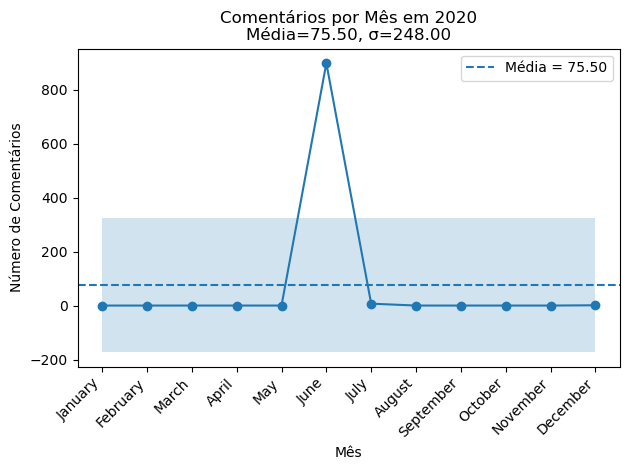

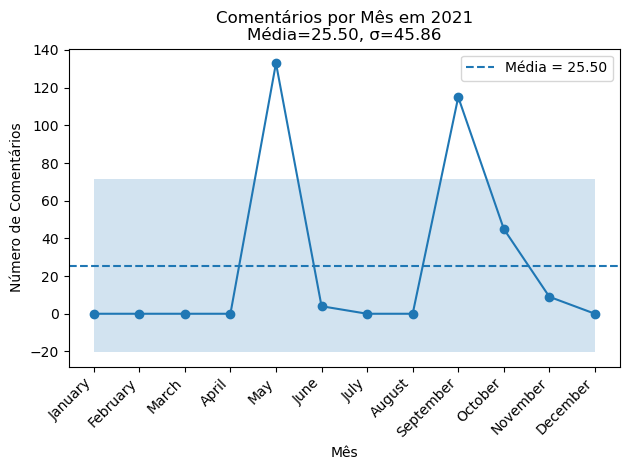

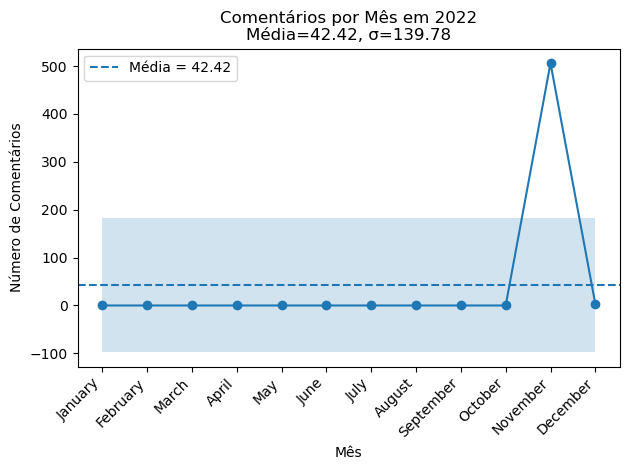

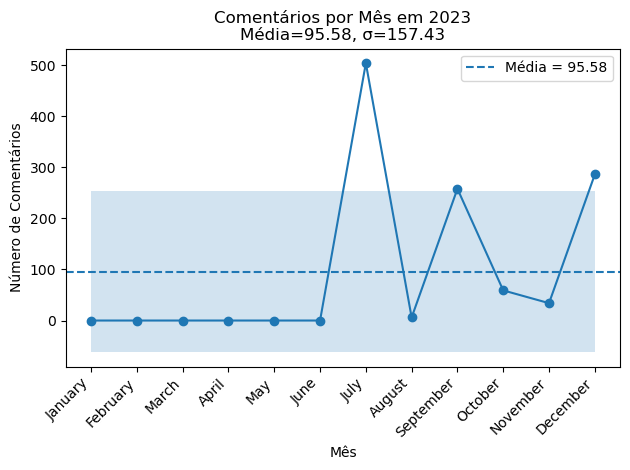

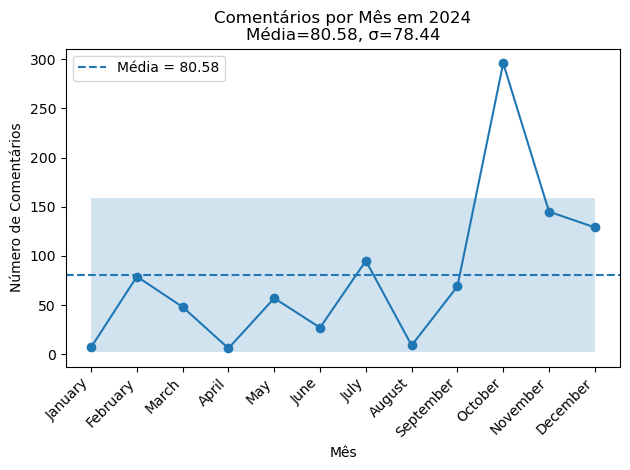

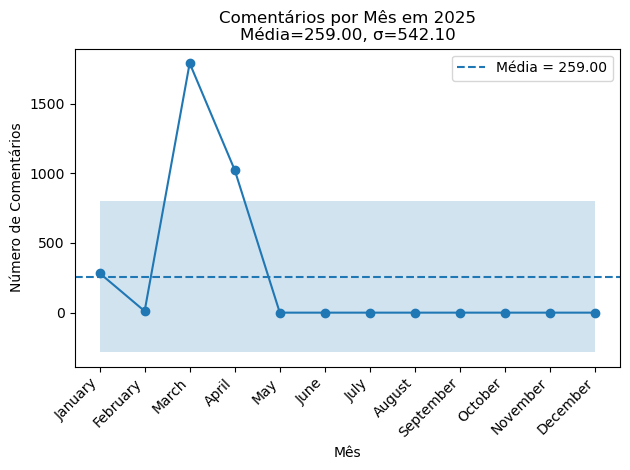

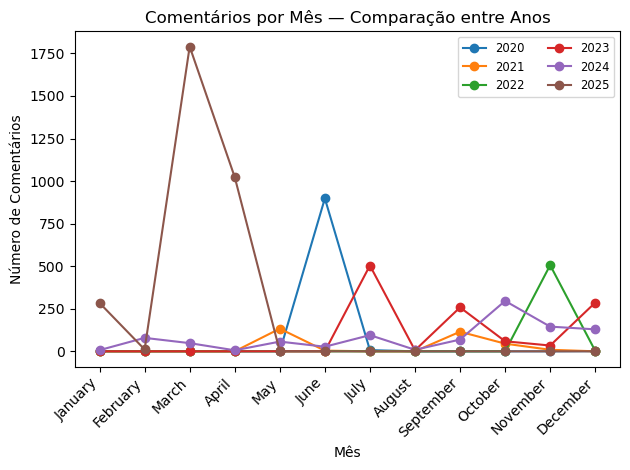

In [6]:
import calendar
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import json
import os
import pandas as pd

# 1. Carrega os dados (caso ainda não tenha sido feito)
df = pd.read_json('form_data/comentarios_video.json')

# 2. Converte datas e filtra
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)
df['year'] = df['published_at'].dt.year
df['month'] = df['published_at'].dt.month
df = df[df['year'] >= 2000]

# 3. Prepara dicionário de resultados por ano
comentarios_por_ano = {}

for year in sorted(df['year'].unique()):
    df_year = df[df['year'] == year]
    comentarios_por_mes = (
        df_year.groupby('month')
               .size()
               .reindex(range(1, 13), fill_value=0)
    )
    valores = comentarios_por_mes.values
    mu = valores.mean()
    sigma = valores.std(ddof=0)

    # Gráfico por ano
    plt.figure()
    plt.plot(comentarios_por_mes.index, valores, marker='o')
    plt.axhline(mu, linestyle='--', label=f'Média = {mu:.2f}')
    plt.fill_between(comentarios_por_mes.index, mu - sigma, mu + sigma, alpha=0.2)
    plt.title(f'Comentários por Mês em {year}\nMédia={mu:.2f}, σ={sigma:.2f}')
    plt.xlabel('Mês')
    plt.ylabel('Número de Comentários')
    labels = [calendar.month_name[m] for m in comentarios_por_mes.index]
    plt.xticks(ticks=comentarios_por_mes.index, labels=labels, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Salva dados do ano
    comentarios_por_ano[str(year)] = {
        "comentarios_por_mes": {str(m): int(q) for m, q in zip(comentarios_por_mes.index, valores)},
        "media": round(mu, 2),
        "desvio_padrao": round(sigma, 2)
    }

# 4. Gráfico combinado de todos os anos
table = (
    df.groupby(['year', 'month'])
      .size()
      .unstack(fill_value=0)
      .reindex(columns=range(1, 13), fill_value=0)
)

plt.figure()
for year, row in table.iterrows():
    plt.plot(row.index, row.values, marker='o', label=str(year))

plt.title('Comentários por Mês — Comparação entre Anos')
plt.xlabel('Mês')
plt.ylabel('Número de Comentários')
plt.xticks(ticks=range(1, 13), labels=[calendar.month_name[m] for m in range(1, 13)], rotation=45, ha='right')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

# 5. Salva em JSON (estrutura centralizada)
pasta_resultados = 'analysis_results'
arquivo_resultados = os.path.join(pasta_resultados, 'analise_ytb.json')

os.makedirs(pasta_resultados, exist_ok=True)

if not os.path.exists(arquivo_resultados):
    with open(arquivo_resultados, 'w', encoding='utf-8') as f:
        json.dump({}, f, ensure_ascii=False, indent=4)

with open(arquivo_resultados, 'r', encoding='utf-8') as f:
    todos_resultados = json.load(f)

# 6. Atualiza a seção
todos_resultados["comentarios_por_mes"] = comentarios_por_ano

with open(arquivo_resultados, 'w', encoding='utf-8') as f:
    json.dump(todos_resultados, f, ensure_ascii=False, indent=4)


Device set to use cpu


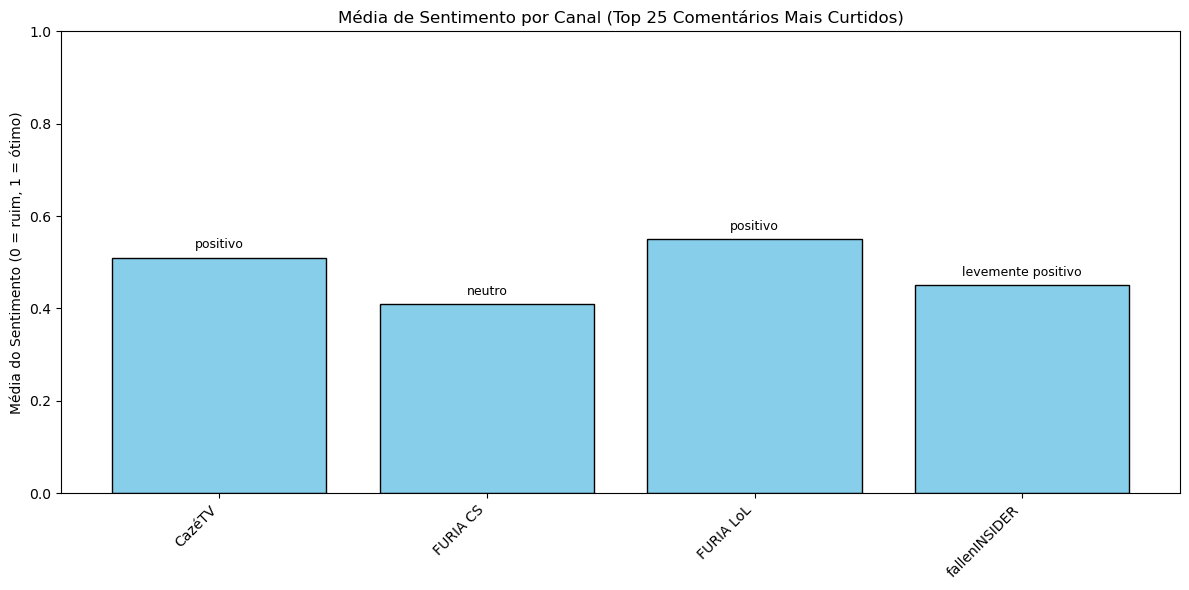

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import os
import json

# 1. Caminho do JSON
JSON_PATH = 'form_data/comentarios_video.json'

# 2. Carrega o DataFrame
df = pd.read_json(JSON_PATH)

# 3. Top 25 comentários mais curtidos por canal
top_por_canal = (
    df.sort_values(['channel_name', 'likes'], ascending=[True, False])
      .groupby('channel_name')
      .head(25)
)

# 4. Pipeline de sentimento
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment",
    device=-1
)

# 5. Aplica o modelo em lotes
def analyze_batch(texts):
    return sentiment_analyzer(texts, truncation=True)

results = []
batch_size = 32
texts = top_por_canal['text'].tolist()
for i in range(0, len(texts), batch_size):
    results.extend(analyze_batch(texts[i:i+batch_size]))

# 6. Processa os resultados
scores, labels = [], []
for res in results:
    stars = int(res['label'][0])
    score = (stars - 1) / 4
    if stars == 1:
        sentiment = "muito negativo"
    elif stars == 2:
        sentiment = "negativo"
    elif stars == 3:
        sentiment = "neutro"
    elif stars == 4:
        sentiment = "positivo"
    else:
        sentiment = "muito positivo"
    scores.append(score)
    labels.append(sentiment)

top_por_canal = top_por_canal.reset_index(drop=True)
top_por_canal['sentiment_score'] = scores
top_por_canal['sentiment'] = labels

# 7. Classificação textual
def classificar_media(score):
    if score <= 0.2:
        return "muito negativo"
    elif score <= 0.3:
        return "negativo"
    elif score <= 0.43:
        return "neutro"
    elif score <= 0.5:
        return "levemente positivo"
    elif score <= 0.65:
        return "positivo"
    elif score <= 0.8:
        return "muito positivo"
    else:
        return "extremamente positivo"

# 8. Agrupa por canal
resumo_canais = (
    top_por_canal.groupby('channel_name')
                 .agg(
                     mean_sentiment_score=('sentiment_score', 'mean'),
                     total_comentarios=('sentiment_score', 'count')
                 )
                 .reset_index()
)

# 9. Classifica
resumo_canais['sentiment_class'] = resumo_canais['mean_sentiment_score'].apply(classificar_media)
resumo_canais['channel_label'] = resumo_canais['channel_name']

# 10. Gráfico
plt.figure(figsize=(12, 6))
bars = plt.bar(resumo_canais['channel_label'], resumo_canais['mean_sentiment_score'], color='skyblue', edgecolor='black')
plt.ylabel('Média do Sentimento (0 = ruim, 1 = ótimo)')
plt.ylim(0, 1)
plt.title('Média de Sentimento por Canal (Top 25 Comentários Mais Curtidos)')
plt.xticks(rotation=45, ha='right')

for bar, label in zip(bars, resumo_canais['sentiment_class']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, label, ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# 11. Salva no JSON
saida = {}
for _, row in resumo_canais.iterrows():
    saida[row['channel_name']] = {
        "media_sentimento": round(row['mean_sentiment_score'], 3),
        "total_comentarios": int(row['total_comentarios']),
        "classificacao": row['sentiment_class']
    }

# Caminho de saída
caminho_pasta = 'analysis_results'
caminho_arquivo = os.path.join(caminho_pasta, 'analise_ytb.json')

os.makedirs(caminho_pasta, exist_ok=True)

if not os.path.exists(caminho_arquivo):
    with open(caminho_arquivo, 'w', encoding='utf-8') as f:
        json.dump({}, f, ensure_ascii=False, indent=4)

with open(caminho_arquivo, 'r', encoding='utf-8') as f:
    dados_atuais = json.load(f)

dados_atuais["sentimento_por_canal"] = saida

with open(caminho_arquivo, 'w', encoding='utf-8') as f:
    json.dump(dados_atuais, f, ensure_ascii=False, indent=4)


#### Análise Geral Reddit

Device set to use cpu


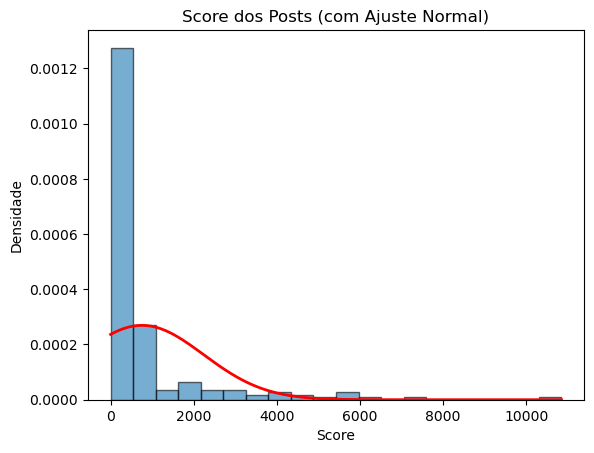

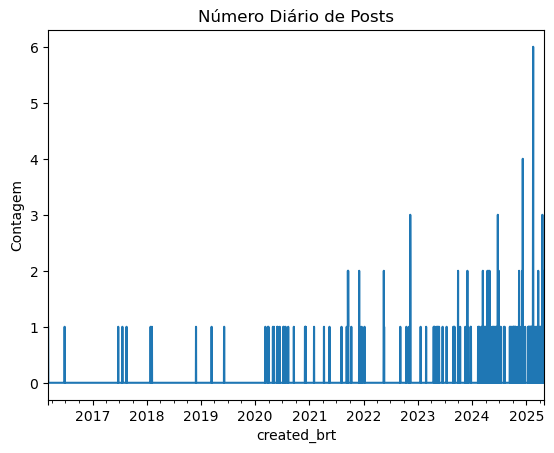

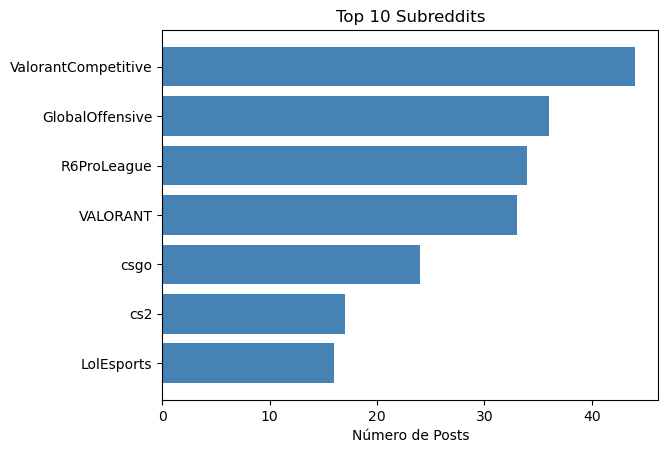

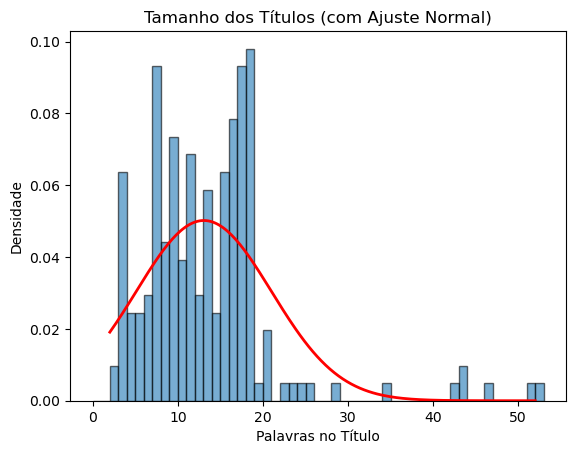

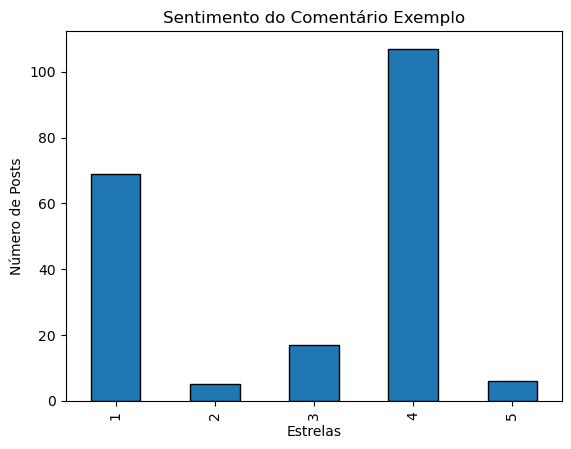

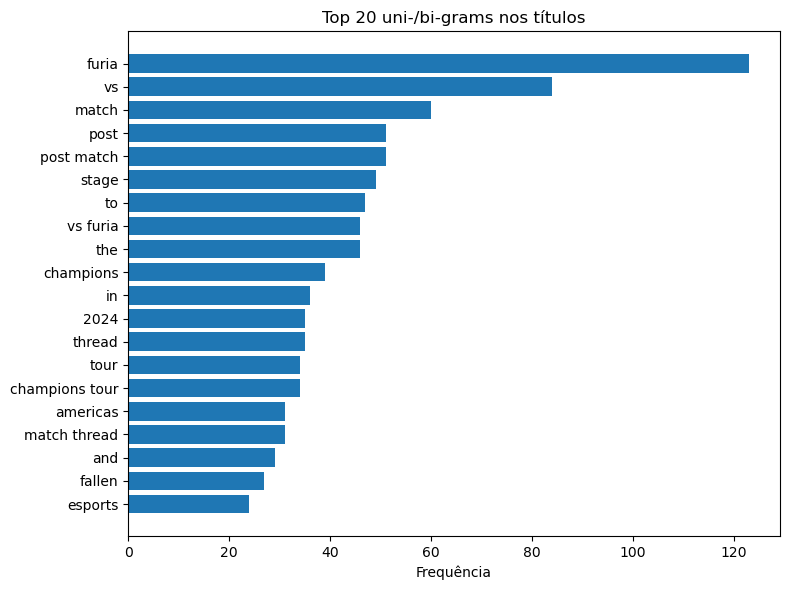

Device set to use cpu
c:\Users\leomo\miniconda3\Lib\site-packages\transformers\pipelines\token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


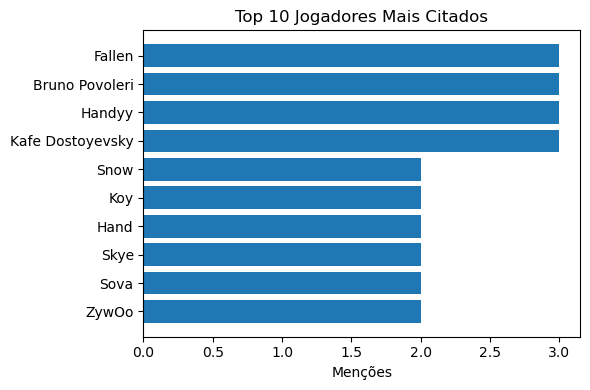

[✓] Resultados da análise do Reddit salvos em analysis_results\analise_reddit.json


In [8]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from scipy.stats import skew

# ====== 0. Parâmetro: caminho para o JSON de entrada ======
JSON_PATH = 'form_data/posts_furia_reddit.json'

# ====== 1. Carregamento ======
def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")
    with open(path, 'r', encoding='utf-8') as f:
        return pd.DataFrame(json.load(f))

# ====== 2. Limpeza ======
def clean_data(df):
    df = df.drop_duplicates(subset=['url'])
    df = df.dropna(subset=['titulo', 'comentario_exemplo']).reset_index(drop=True)
    return df

# ====== 3. Featurização ======
def engineer_features(df):
    df['created_utc'] = pd.to_datetime(df['data_criacao'], unit='s', utc=True)
    df['created_brt'] = df['created_utc'].dt.tz_convert('America/Sao_Paulo')
    df['titulo_len_chars'] = df['titulo'].str.len()
    df['titulo_len_words'] = df['titulo'].str.split().apply(len)
    df['weekday'] = df['created_brt'].dt.day_name(locale='pt_BR')
    df['hour']    = df['created_brt'].dt.hour
    return df

# ====== 4. Análise de Sentimento ======
def analyze_sentiment(df):
    nltk.download('stopwords', quiet=True)
    pt_stop = stopwords.words('portuguese')
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model="nlptown/bert-base-multilingual-uncased-sentiment",
        tokenizer="nlptown/bert-base-multilingual-uncased-sentiment"
    )
    df['sentiment_score'] = df['comentario_exemplo'].apply(
        lambda t: int(sentiment_analyzer(t[:512], truncation=True)[0]['label'][0])
    )
    return df, pt_stop

# ====== 5. Extração de jogadores via NER ======
def extract_player_mentions(df):
    ner = pipeline(
        "ner",
        model="Davlan/bert-base-multilingual-cased-ner-hrl",
        tokenizer="Davlan/bert-base-multilingual-cased-ner-hrl",
        grouped_entities=True
    )
    texts = pd.concat([df['titulo'], df['comentario_exemplo']]).unique()
    mentions = []
    for txt in texts:
        entities = ner(txt[:512])
        mentions += [e['word'] for e in entities if e['entity_group'] == 'PER']
    return Counter(mentions)

# ====== 6. Plots Estatísticos ======
def plot_score_distribution(df):
    scores = df['score']
    μ, σ = scores.mean(), scores.std(ddof=0)
    plt.figure()
    plt.hist(scores, bins=20, density=True, alpha=0.6, edgecolor='black')
    x = np.linspace(scores.min(), scores.max(), 200)
    pdf = (1/(σ*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-μ)/σ)**2)
    plt.plot(x, pdf, 'r-', lw=2)
    plt.title('Score dos Posts (com Ajuste Normal)')
    plt.xlabel('Score')
    plt.ylabel('Densidade')
    plt.show()

def plot_time_series(df):
    serie = df.set_index('created_brt').resample('D').size()
    plt.figure()
    serie.plot()
    plt.title('Número Diário de Posts')
    plt.ylabel('Contagem')
    plt.show()

def plot_top_subreddits(df):
    top = df['subreddit'].value_counts().head(10)
    plt.figure()
    plt.barh(top.index[::-1], top.values[::-1], color='steelblue')
    plt.title('Top 10 Subreddits')
    plt.xlabel('Número de Posts')
    plt.show()

def plot_title_length_distribution(df):
    lengths = df['titulo_len_words']
    μ, σ = lengths.mean(), lengths.std(ddof=0)
    plt.figure()
    plt.hist(lengths, bins=range(0, int(lengths.max())+2), density=True, alpha=0.6, edgecolor='black')
    x = np.linspace(lengths.min(), lengths.max(), 200)
    pdf = (1/(σ*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-μ)/σ)**2)
    plt.plot(x, pdf, 'r-', lw=2)
    plt.title('Tamanho dos Títulos (com Ajuste Normal)')
    plt.xlabel('Palavras no Título')
    plt.ylabel('Densidade')
    plt.show()

def plot_sentiment_distribution(df):
    counts = df['sentiment_score'].value_counts().sort_index()
    plt.figure()
    counts.plot(kind='bar', edgecolor='black')
    plt.title('Sentimento do Comentário Exemplo')
    plt.xlabel('Estrelas')
    plt.ylabel('Número de Posts')
    plt.show()

def plot_ngrams(df, stop_words, top_n=20):
    vec = CountVectorizer(ngram_range=(1,2), stop_words=stop_words)
    X = vec.fit_transform(df['titulo'])
    sums = X.sum(axis=0)
    termos_contagens = [
        (termo, int(sums[0, idx]))
        for termo, idx in vec.vocabulary_.items()
    ]
    top_terms = sorted(termos_contagens, key=lambda x: x[1], reverse=True)[:top_n]
    labels, freqs = zip(*top_terms)
    plt.figure(figsize=(8,6))
    plt.barh(labels[::-1], freqs[::-1])
    plt.title(f'Top {top_n} uni-/bi-grams nos títulos')
    plt.xlabel('Frequência')
    plt.tight_layout()
    plt.show()

def plot_player_mentions(counter, top_n=10):
    most = counter.most_common(top_n)
    players, freqs = zip(*most)
    plt.figure(figsize=(6,4))
    plt.barh(players[::-1], freqs[::-1])
    plt.title(f'Top {top_n} Jogadores Mais Citados')
    plt.xlabel('Menções')
    plt.tight_layout()
    plt.show()

# ====== 7. Main ======
def main():
    # Carregamento, limpeza e featurização
    df = load_data(JSON_PATH)
    df = clean_data(df)
    df = engineer_features(df)

    # Sentimento e stopwords
    df, pt_stop = analyze_sentiment(df)

    # Plots
    plot_score_distribution(df)
    plot_time_series(df)
    plot_top_subreddits(df)
    plot_title_length_distribution(df)
    plot_sentiment_distribution(df)
    plot_ngrams(df, pt_stop, top_n=20)

    # NER de jogadores
    counter_players = extract_player_mentions(df)
    plot_player_mentions(counter_players, top_n=10)

    # Estatísticas resumidas
    sentiment_stats = {
        "media":         round(df['sentiment_score'].mean(), 2),
        "desvio_padrao": round(df['sentiment_score'].std(ddof=0), 2),
        "mediana":       round(df['sentiment_score'].median(), 2),
        "assimetria":    round(skew(df['sentiment_score']), 2)
    }
    top_subreddits = df['subreddit'].value_counts().head(10).to_dict()

    # top_ngrams corrigido
    vec = CountVectorizer(ngram_range=(1,2), stop_words=pt_stop)
    X = vec.fit_transform(df['titulo'])
    sums = X.sum(axis=0)
    termos_contagens = [
        (termo, int(sums[0, idx]))
        for termo, idx in vec.vocabulary_.items()
    ]
    top_ngrams = dict(sorted(termos_contagens, key=lambda x: x[1], reverse=True)[:20])

    top_players = dict(counter_players.most_common(10))

    resultados_reddit = {
        "total_posts":            int(df.shape[0]),
        "posts_limpos":           int(df.drop_duplicates('url').shape[0]),
        "estatisticas_sentimento": sentiment_stats,
        "top_subreddits":         top_subreddits,
        "top_ngrams":             top_ngrams,
        "top_player_mentions":    top_players
    }

    # Salvando JSON
    pasta = 'analysis_results'
    arquivo = os.path.join(pasta, 'analise_reddit.json')
    os.makedirs(pasta, exist_ok=True)
    if not os.path.exists(arquivo):
        with open(arquivo, 'w', encoding='utf-8') as f:
            json.dump({}, f, ensure_ascii=False, indent=4)
    with open(arquivo, 'r', encoding='utf-8') as f:
        todos = json.load(f)
    todos["analise_reddit"] = resultados_reddit
    with open(arquivo, 'w', encoding='utf-8') as f:
        json.dump(todos, f, ensure_ascii=False, indent=4)

    print(f"[✓] Resultados da análise do Reddit salvos em {arquivo}")

if __name__ == "__main__":
    main()


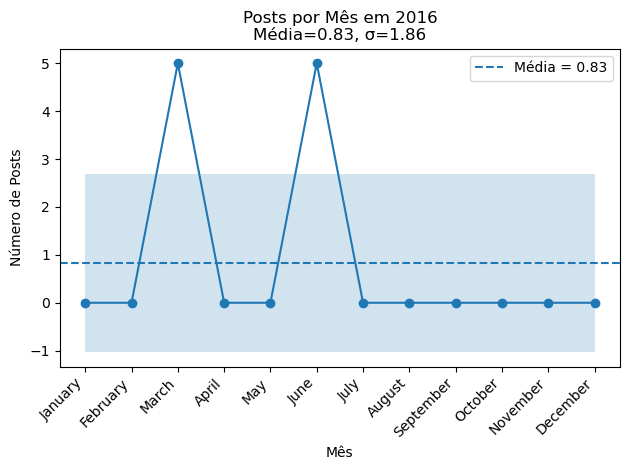

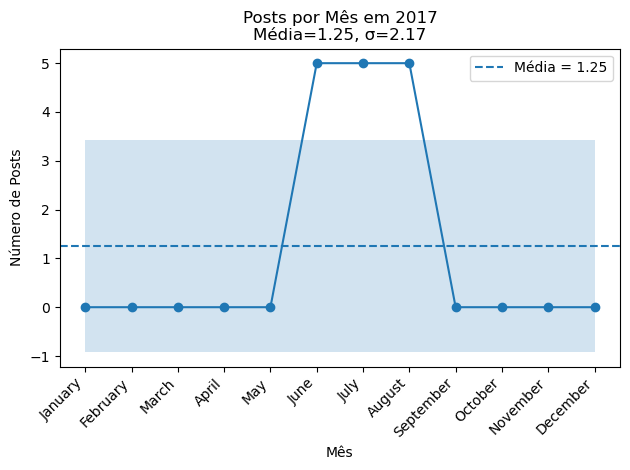

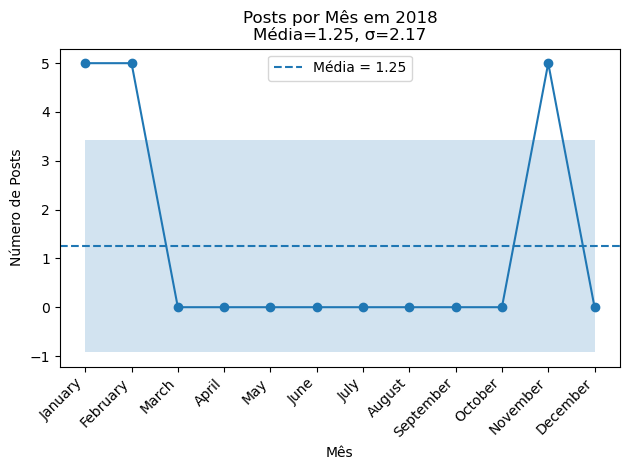

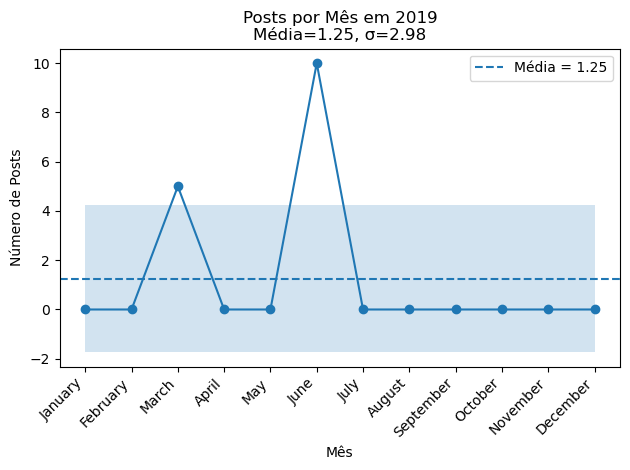

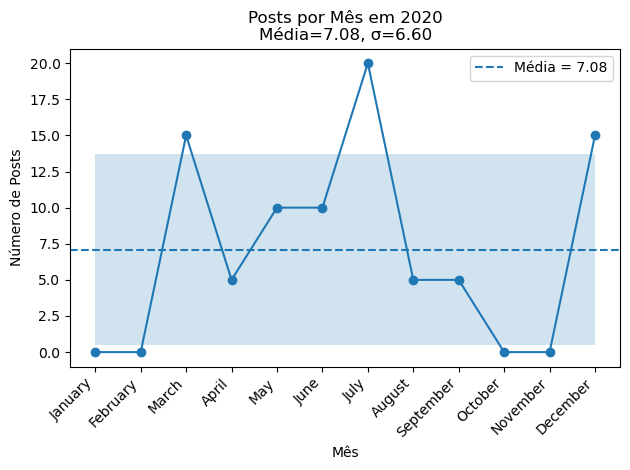

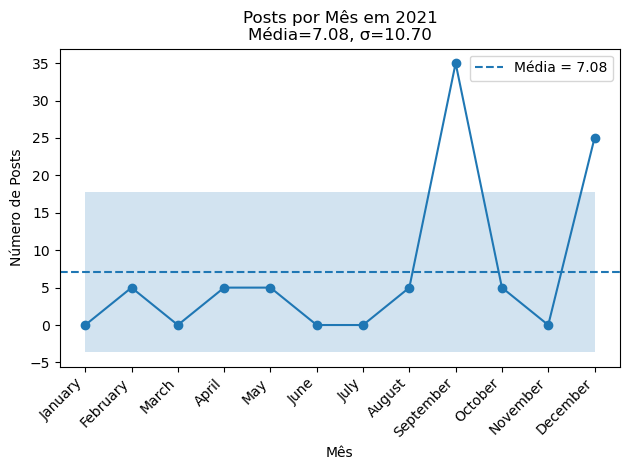

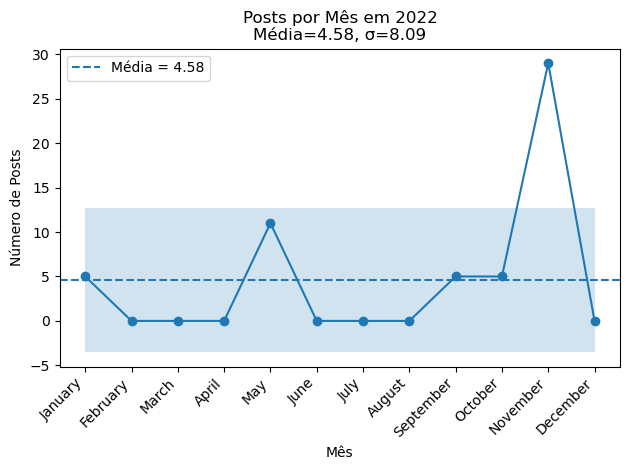

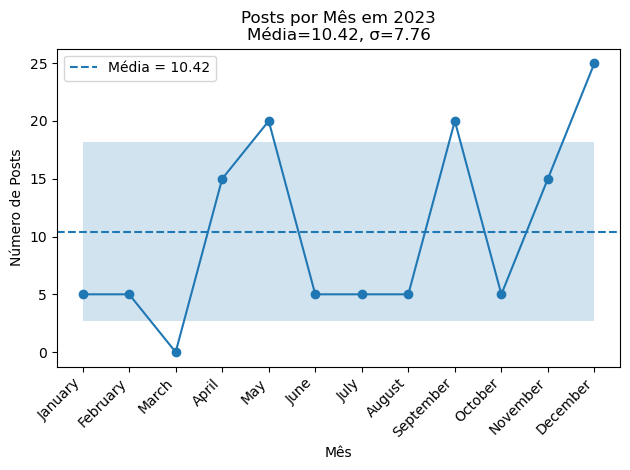

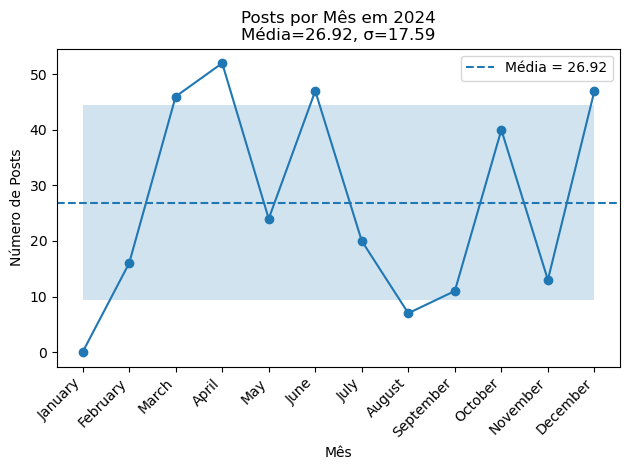

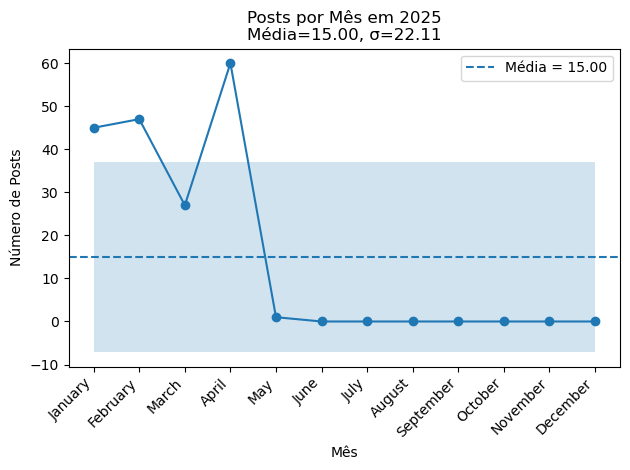

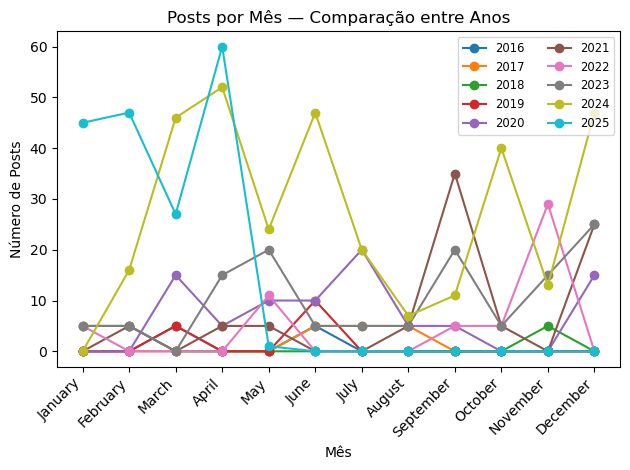

In [9]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# --- Parâmetros ---
INPUT_JSON   = 'form_data/posts_furia_reddit.json'
RESULTS_DIR  = 'analysis_results'
RESULTS_FILE = os.path.join(RESULTS_DIR, 'analise_reddit.json')

# 1. Carrega posts e extrai ano/mês
posts = pd.read_json(INPUT_JSON)
posts['data_criacao'] = pd.to_datetime(posts['data_criacao'], unit='s', utc=True)
posts['year']  = posts['data_criacao'].dt.year
posts['month'] = posts['data_criacao'].dt.month

# 2. Filtra anos >=2000
posts = posts[posts['year'] >= 2000]

# 3. Calcula estatísticas mensais
monthly_stats = {}
for year, grp in posts.groupby('year'):
    counts = grp.groupby('month').size().reindex(range(1,13), fill_value=0)
    vals   = counts.values
    mu     = float(vals.mean())
    sigma  = float(vals.std(ddof=0))
    monthly_stats[str(year)] = {
        "counts": {str(m): int(counts.loc[m]) for m in counts.index},
        "media": round(mu, 2),
        "desvio_padrao": round(sigma, 2)
    }

# 4. Estatística combinada
pivot = posts.groupby(['year','month']).size().unstack(fill_value=0)
combined = {
    str(year): [int(v) for v in row.values]
    for year, row in pivot.iterrows()
}

# 5. Salva no JSON do Reddit
os.makedirs(RESULTS_DIR, exist_ok=True)
if not os.path.exists(RESULTS_FILE):
    with open(RESULTS_FILE, 'w', encoding='utf-8') as f:
        json.dump({}, f, ensure_ascii=False, indent=4)

with open(RESULTS_FILE, 'r', encoding='utf-8') as f:
    all_results = json.load(f)

all_results.setdefault('analise_reddit', {})
all_results['analise_reddit']['monthly_time_series'] = {
    "per_year": monthly_stats,
    "combined": combined
}

with open(RESULTS_FILE, 'w', encoding='utf-8') as f:
    json.dump(all_results, f, ensure_ascii=False, indent=4)

# 6. Plotagem

# 6.1 Gráficos por ano
for year, stats in monthly_stats.items():
    meses = list(range(1,13))
    vals  = list(stats["counts"].values())
    μ, σ  = stats["media"], stats["desvio_padrao"]

    plt.figure()
    plt.plot(meses, vals, marker='o')
    plt.axhline(μ, linestyle='--', label=f"Média = {μ:.2f}")
    plt.fill_between(meses, [μ-σ]*12, [μ+σ]*12, alpha=0.2)
    plt.title(f"Posts por Mês em {year}\nMédia={μ:.2f}, σ={σ:.2f}")
    plt.xlabel("Mês")
    plt.ylabel("Número de Posts")
    plt.xticks(ticks=meses,
               labels=[calendar.month_name[m] for m in meses],
               rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 6.2 Gráfico combinado
plt.figure()
for year, vals in combined.items():
    plt.plot(meses, vals, marker='o', label=year)
plt.title("Posts por Mês — Comparação entre Anos")
plt.xlabel("Mês")
plt.ylabel("Número de Posts")
plt.xticks(ticks=meses,
           labels=[calendar.month_name[m] for m in meses],
           rotation=45, ha='right')
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

##### Horário de Maior Ativiade

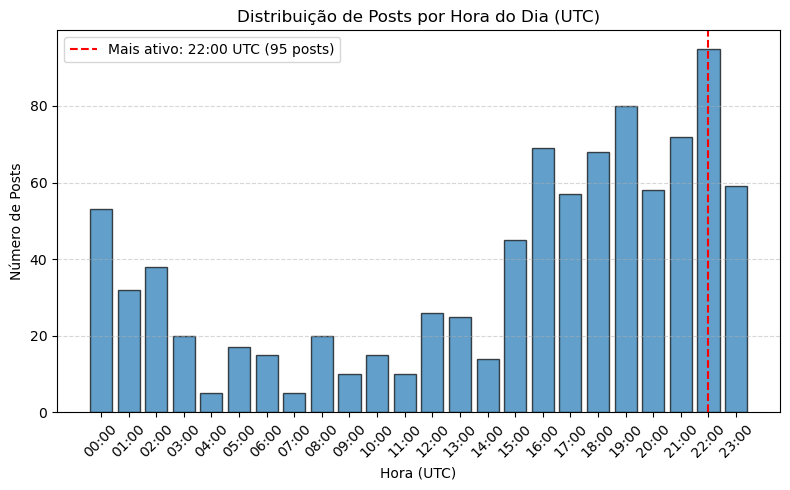

In [10]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# ====== 1. Caminho para o JSON Reddit ======
DATA_DIR = 'form_data'
REDDIT_JSON = os.path.join(DATA_DIR, 'posts_furia_reddit.json')

# ====== 2. Carrega dados ======
with open(REDDIT_JSON, 'r', encoding='utf-8') as f:
    posts = json.load(f)

df = pd.DataFrame(posts)

# ====== 3. Converte timestamp e extrai hora UTC ======
# supondo campo 'data_criacao' em epoch seconds
if df['data_criacao'].dtype != 'datetime64[ns, UTC]':
    df['data_criacao'] = pd.to_datetime(df['data_criacao'], unit='s', utc=True)
df['hour_utc'] = df['data_criacao'].dt.hour

# ====== 4. Conta posts por hora ======
hourly_counts = df['hour_utc'].value_counts().sort_index()

# ====== 5. Identifica hora de maior atividade ======
most_active_hour = hourly_counts.idxmax()
most_active_count = hourly_counts.max()

# ====== 6. Plot de distribuição horária ======
plt.figure(figsize=(8,5))
plt.bar(hourly_counts.index, hourly_counts.values, edgecolor='black', alpha=0.7)
plt.axvline(most_active_hour, color='red', linestyle='--',
            label=f'Mais ativo: {most_active_hour:02d}:00 UTC ({most_active_count} posts)')

plt.title('Distribuição de Posts por Hora do Dia (UTC)')
plt.xlabel('Hora (UTC)')
plt.ylabel('Número de Posts')
plt.xticks(ticks=range(0,24), labels=[f"{h:02d}:00" for h in range(24)], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Análise Geral Twitter

##### Análise de Sentimento

Device set to use cpu
C:\Users\leomo\AppData\Local\Temp\ipykernel_17524\170389969.py:123: UserWarning: Glyph 128153 (\N{BLUE HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leomo\AppData\Local\Temp\ipykernel_17524\170389969.py:123: UserWarning: Glyph 129763 (\N{FACE WITH PEEKING EYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leomo\AppData\Local\Temp\ipykernel_17524\170389969.py:123: UserWarning: Glyph 128420 (\N{BLACK HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leomo\AppData\Local\Temp\ipykernel_17524\170389969.py:123: UserWarning: Glyph 129293 (\N{WHITE HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leomo\AppData\Local\Temp\ipykernel_17524\170389969.py:123: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leomo\AppData\Local\Temp\ipykernel_17524\170389969.py:123: UserWarning: Glyph 129395 (\N{FACE WITH PARTY HORN AND PARTY HA

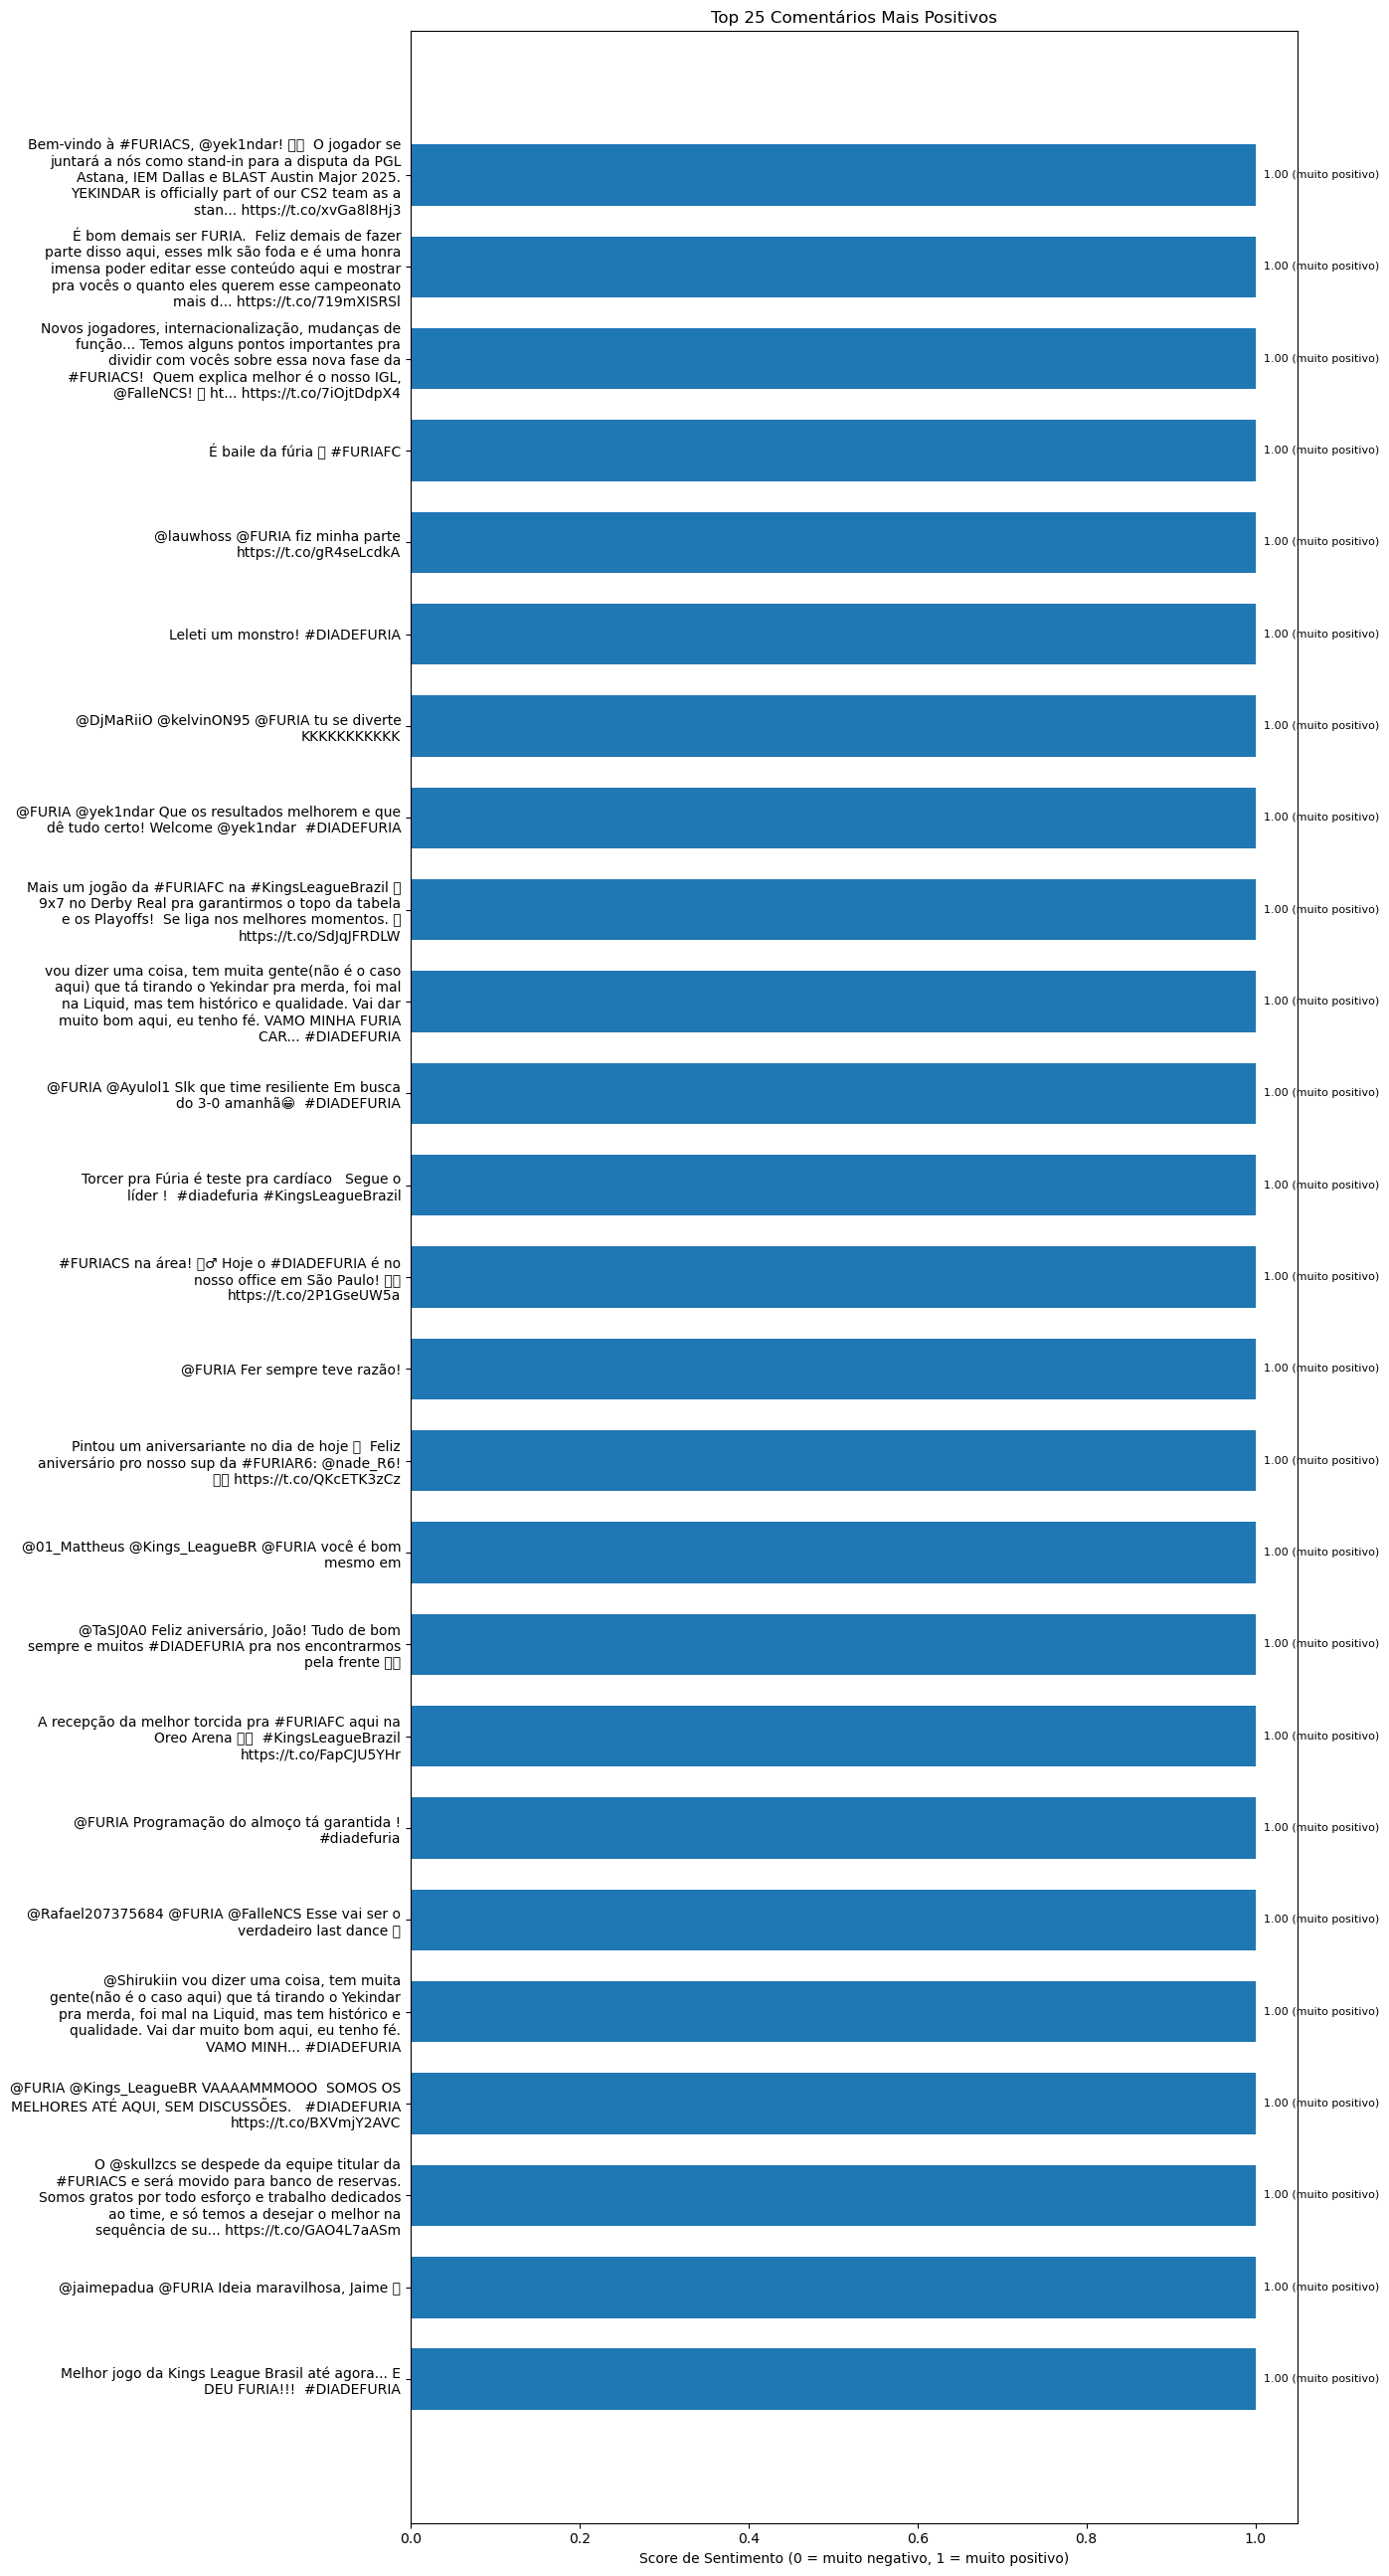

In [12]:
# Correção para o NameError: df0 não definido

import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import textwrap
import json
import random

# ====== 1. Carrega os dados JSON ======
with open(r'form_data/tweets_furia.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Criar df0 antes de qualquer filtragem para manter os totais originais
df0 = pd.DataFrame(data)

# Trabalhar em uma cópia para filtros
df = df0.copy()

# ====== 2. Remove duplicatas pelo texto e filtra pt ======
df = df.drop_duplicates(subset=['text'])
df = df[df['lang'] == 'pt'].copy()

# ====== 3. Simula likes ======
df['likes'] = [random.randint(1, 5000) for _ in range(len(df))]

# ====== 4. Seleciona os 200 mais curtidos ======
top200 = df.sort_values('likes', ascending=False).head(200).copy()

# ====== 5. Remove palavras banidas ======
palavras_banidas = ['CAPIM', 'Desempedidos', 'G3X', 'g3x', 
                    'DENDELE', 'LOUD', 'FUNKBOL', 'FLUXO REAL ELITE']
mask = ~top200['text'].str.upper().str.contains('|'.join(palavras_banidas))
top200_filtrado = top200[mask].reset_index(drop=True)

# ====== 6. Pipeline de sentimento ======
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment"
)

# ====== 7. Aplica o modelo ======
batch_size = 32
texts = top200_filtrado['text'].tolist()
results = []
for i in range(0, len(texts), batch_size):
    batch = texts[i:i + batch_size]
    results.extend(sentiment_analyzer(batch, truncation=True))

# ====== 8. Normaliza scores ======
scores = [(int(r['label'][0]) - 1) / 4 for r in results]
top200_filtrado['sentiment_score'] = scores

# ====== 9. Pega os TOP 25 mais positivos ======
top25 = top200_filtrado.sort_values('sentiment_score', ascending=False).head(25).copy()

# ====== 10. Funções auxiliares ======
def simplificar_comentario(texto, limite=200):
    if len(texto) <= limite:
        return texto
    palavras = texto.split()
    ultima_palavra = palavras[-1] if palavras else ''
    return f"{texto[:limite].rstrip()}... {ultima_palavra}"

def estrela_para_sentimento(score):
    stars = int(round(score * 4)) + 1
    return {
        1: "muito negativo",
        2: "negativo",
        3: "neutro",
        4: "positivo",
        5: "muito positivo"
    }[stars]

# Geração do dicionário de resultados, usando df0 para totais originais
res = {
    "total_tweets":      int(df0.shape[0]),
    "tweets_unicos":     int(df.shape[0]),
    "tweets_pt":         int(df.lang.eq('pt').sum()),
    "top200_considered": int(top200.shape[0]),
    "top25_final":       int(top25.shape[0]),
    "sentiment_stats": {
        "mean": round(float(top25.sentiment_score.mean()),2),
        "std":  round(float(top25.sentiment_score.std(ddof=0)),2)
    },
    "top25": [
        {"text": textwrap.shorten(t, width=100, placeholder="..."),
         "score": round(s,2),
         "label": estrela_para_sentimento(s)}
        for t,s in zip(top25.text, top25.sentiment_score)
    ]
}

# ====== 11. Salva JSON e plota ======
os.makedirs('analysis_results', exist_ok=True)
with open('analysis_results/analise_twitter.json','w',encoding='utf-8') as f:
    json.dump({"analise_twitter": res}, f, ensure_ascii=False, indent=4)

# Plot dos Top 25
def plot_top25(df):
    comentarios = [
        textwrap.fill(simplificar_comentario(t), width=50)
        for t in df['text']
    ]
    scores = df['sentiment_score'].tolist()

    spacing = 1.2
    y_pos = [i * spacing for i in range(len(comentarios))][::-1]

    plt.figure(figsize=(14, len(df) * spacing * 0.8 + 2))
    plt.barh(y_pos, scores)
    plt.yticks(y_pos, comentarios)
    plt.xlabel('Score de Sentimento (0 = muito negativo, 1 = muito positivo)')
    plt.title('Top 25 Comentários Mais Positivos')
    plt.gca().invert_yaxis()

    for y, s in zip(y_pos, scores):
        plt.text(s + 0.01, y, f'{s:.2f} ({estrela_para_sentimento(s)})',
                 va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_top25(top25)


##### Frequência de Tweets (Intervalo de 3h)

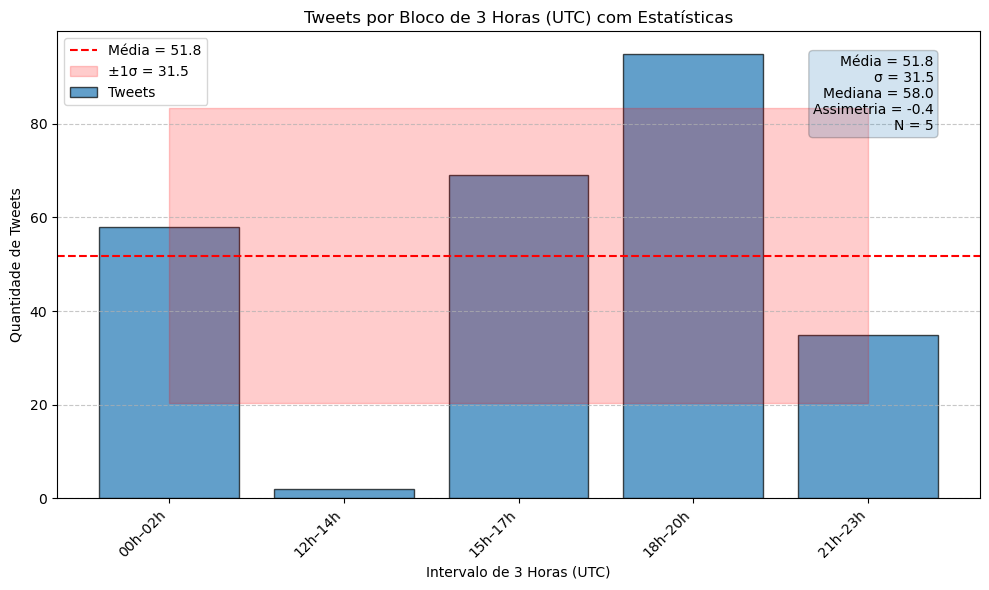

In [13]:
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
IN_JSON    = 'form_data/tweets_furia.json'
OUT_DIR    = 'analysis_results'
OUT_JSON   = os.path.join(OUT_DIR, 'analise_twitter.json')

# 1. Carrega dados
with open(IN_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.DataFrame(data)

# 2. Extrai hora UTC e agrupa em blocos de 3h
df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
df['hora_utc']   = df['created_at'].dt.hour
df['bloco_3h']   = df['hora_utc'].apply(lambda h: f"{(h//3)*3:02d}h–{(h//3)*3+2:02d}h")

# 3. Conta por bloco e calcula estatísticas
freq       = df['bloco_3h'].value_counts().sort_index()
vals       = freq.values
stats_time = {
    "counts":       freq.to_dict(),
    "media":        round(float(vals.mean()), 2),
    "desvio_padrao":round(float(vals.std(ddof=0)), 2),
    "mediana":      round(float(np.median(vals)), 2),
    "assimetria":   round(float(pd.Series(vals).skew()), 2),
    "n_blocos":     int(len(vals))
}

# 4. Atualiza JSON existente
os.makedirs(OUT_DIR, exist_ok=True)
if not os.path.exists(OUT_JSON):
    with open(OUT_JSON, 'w', encoding='utf-8') as f:
        json.dump({}, f, ensure_ascii=False, indent=4)

with open(OUT_JSON, 'r', encoding='utf-8') as f:
    all_res = json.load(f)

all_res.setdefault('analise_twitter', {})
all_res['analise_twitter']['time_blocks_3h'] = stats_time

with open(OUT_JSON, 'w', encoding='utf-8') as f:
    json.dump(all_res, f, ensure_ascii=False, indent=4)

# 5. Plotagem
x = list(freq.index)
y = list(vals)
positions = np.arange(len(x))

plt.figure(figsize=(10,6))
plt.bar(positions, y, edgecolor='black', alpha=0.7, label='Tweets')
plt.axhline(stats_time['media'], color='red', linestyle='--', label=f"Média = {stats_time['media']}")
plt.fill_between(positions,
                 stats_time['media'] - stats_time['desvio_padrao'],
                 stats_time['media'] + stats_time['desvio_padrao'],
                 color='red', alpha=0.2, label=f"±1σ = {stats_time['desvio_padrao']}")

plt.xticks(positions, x, rotation=45, ha='right')
plt.xlabel('Intervalo de 3 Horas (UTC)')
plt.ylabel('Quantidade de Tweets')
plt.title('Tweets por Bloco de 3 Horas (UTC) com Estatísticas')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# estatísticas no canto
txt = (
    f"Média = {stats_time['media']}\n"
    f"σ = {stats_time['desvio_padrao']}\n"
    f"Mediana = {stats_time['mediana']}\n"
    f"Assimetria = {stats_time['assimetria']}\n"
    f"N = {stats_time['n_blocos']}"
)
plt.gca().text(0.95, 0.95, txt, transform=plt.gca().transAxes,
               va='top', ha='right', fontsize=10,
               bbox=dict(boxstyle='round', alpha=0.2))

plt.legend()
plt.tight_layout()
plt.show()


##### Localização

C:\Users\leomo\AppData\Local\Temp\ipykernel_17524\1841577886.py:50: UserWarning: Glyph 128062 (\N{PAW PRINTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\leomo\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128062 (\N{PAW PRINTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


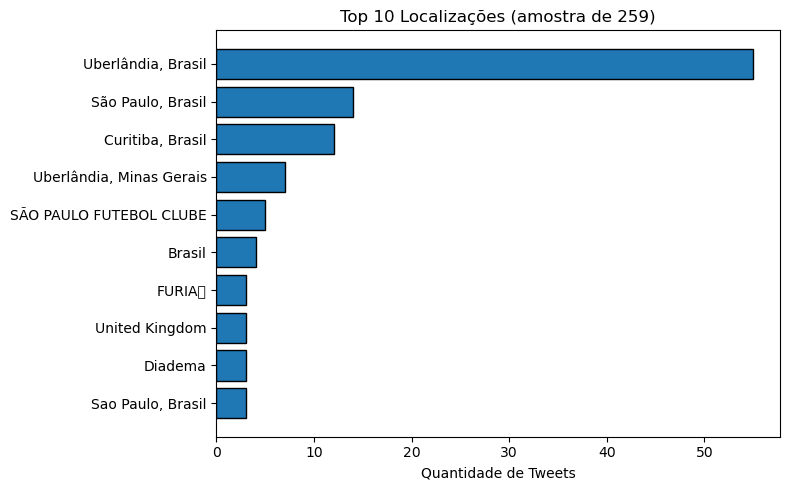

In [14]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt

# Parâmetros
IN_JSON     = 'form_data/tweets_furia.json'
OUT_DIR     = 'analysis_results'
OUT_JSON    = os.path.join(OUT_DIR, 'analise_twitter.json')
SAMPLE_SIZE = 500

# 1. Carrega e amostra
with open(IN_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.DataFrame(data)
if len(df) > SAMPLE_SIZE:
    df = df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)

# 2. Extrai e filtra localização
df['localizacao'] = df['user'].apply(lambda u: u.get('location') if isinstance(u, dict) else None)
locs = df['localizacao'].dropna().str.strip()
locs = locs[locs != '']

# 3. Top 10 locais
top_locs = locs.value_counts().head(10)
loc_stats = {loc: int(cnt) for loc, cnt in top_locs.items()}

# 4. Salva no JSON existente
os.makedirs(OUT_DIR, exist_ok=True)
if not os.path.exists(OUT_JSON):
    with open(OUT_JSON, 'w', encoding='utf-8') as f:
        json.dump({}, f, ensure_ascii=False, indent=4)

with open(OUT_JSON, 'r', encoding='utf-8') as f:
    all_res = json.load(f)

all_res.setdefault('analise_twitter', {})
all_res['analise_twitter']['location_distribution'] = {
    "sample_size": len(df),
    "top_10": loc_stats
}

with open(OUT_JSON, 'w', encoding='utf-8') as f:
    json.dump(all_res, f, ensure_ascii=False, indent=4)

# 5. Plota
plt.figure(figsize=(8,5))
plt.barh(list(loc_stats.keys())[::-1], list(loc_stats.values())[::-1], edgecolor='black')
plt.xlabel('Quantidade de Tweets')
plt.title(f'Top 10 Localizações (amostra de {len(df)})')
plt.tight_layout()
plt.show()


##### Idade das Contas

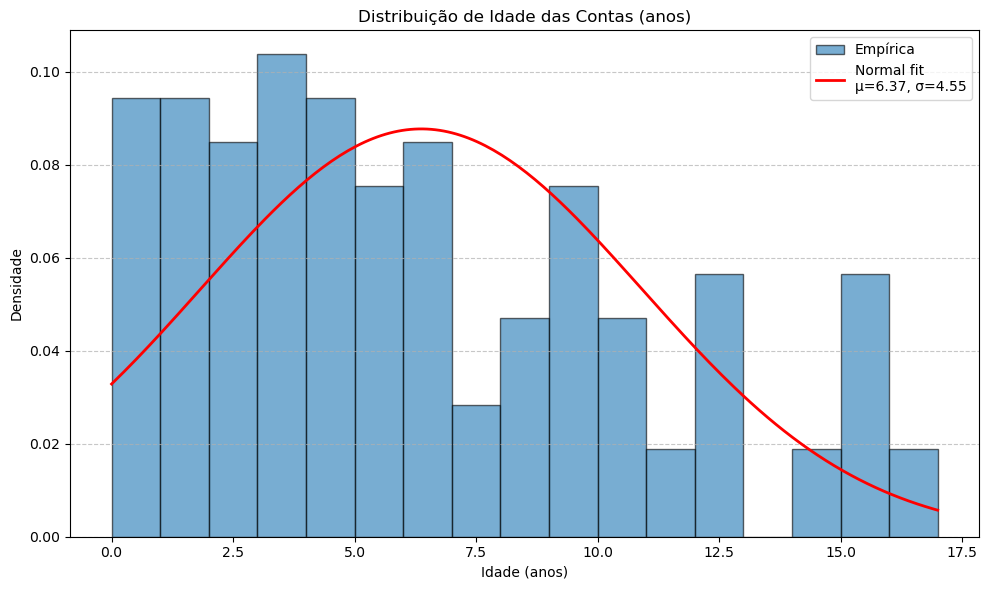

In [15]:
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
IN_JSON   = 'form_data/tweets_furia.json'
OUT_DIR   = 'analysis_results'
OUT_JSON  = os.path.join(OUT_DIR, 'analise_twitter.json')
HOJE      = pd.Timestamp('2025-05-01', tz='UTC')

# 1. Carrega dados e calcula idade das contas
with open(IN_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df['created_at'] = pd.to_datetime(
    df['user'].apply(lambda u: u.get('created_at') if isinstance(u, dict) else None),
    utc=True, errors='coerce'
)
df = df.dropna(subset=['created_at'])
df['age'] = (HOJE - df['created_at']).dt.days / 365.25

# 2. Remove duplicatas de autor e monta histograma
unique = df.drop_duplicates('author_id')
ages   = unique['age']
bins   = range(0, int(ages.max()) + 2)
counts, edges = np.histogram(ages, bins=bins)

# 3. Estatísticas
stats_age = {
    "counts": {str(int(edges[i])): int(counts[i]) for i in range(len(counts))},
    "media": round(float(ages.mean()), 2),
    "desvio_padrao": round(float(ages.std(ddof=0)), 2),
    "mediana": round(float(ages.median()), 2),
    "n_bins": len(counts)
}

# 4. Salva no JSON existente
os.makedirs(OUT_DIR, exist_ok=True)
data_out = json.load(open(OUT_JSON)) if os.path.exists(OUT_JSON) else {}
data_out.setdefault('analise_twitter', {})['account_age_distribution'] = stats_age
with open(OUT_JSON, 'w', encoding='utf-8') as f:
    json.dump(data_out, f, ensure_ascii=False, indent=4)

# 5. Plotagem
plt.figure(figsize=(10,6))
plt.hist(ages, bins=bins, density=True, alpha=0.6, edgecolor='black', label='Empírica')
x = np.linspace(edges[0], edges[-1], 200)
μ, σ = ages.mean(), ages.std(ddof=0)
pdf = 1/(σ*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-μ)/σ)**2)
plt.plot(x, pdf, 'r-', linewidth=2, label=f'Normal fit\nμ={μ:.2f}, σ={σ:.2f}')
plt.title('Distribuição de Idade das Contas (anos)')
plt.xlabel('Idade (anos)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Visualização Geral/Abrangente 

#### Dashbord Geral

In [16]:
import json
import os
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import norm
import dash
from dash import dcc, html
import plotly.graph_objects as go
import plotly.express as px

# === 1. Carrega os dados ===
try:
    BASE_DIR = os.path.dirname(__file__)
except NameError:
    BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'analysis_results')

REDDIT_JSON = os.path.join(DATA_DIR, 'analise_reddit.json')
TWITTER_JSON = os.path.join(DATA_DIR, 'analise_twitter.json')
YTB_JSON = os.path.join(DATA_DIR, 'analise_ytb.json')

with open(REDDIT_JSON, 'r', encoding='utf-8') as f:
    reddit = json.load(f)['analise_reddit']
with open(TWITTER_JSON, 'r', encoding='utf-8') as f:
    twitter = json.load(f)['analise_twitter']
with open(YTB_JSON, 'r', encoding='utf-8') as f:
    ytb = json.load(f)

# === 2. Processamento ===
yt_top = ytb['top_10_comentarios']
yt_monthly = ytb['comentarios_por_mes']
yt_values = [c['likes'] for c in yt_top]
yt_mu, yt_std = np.mean(yt_values), np.std(yt_values)

reddit_anos = reddit['monthly_time_series']['combined']
reddit_values = []
for ano, meses in reddit_anos.items():
    reddit_values.extend(meses)
reddit_mu, reddit_std = np.mean(reddit_values), np.std(reddit_values)
subreddits = reddit['top_subreddits']
ngrams = {k: v for k, v in reddit['top_ngrams'].items() if k.isalpha()}

tweet_hours_dict = twitter['time_blocks_3h']['counts']
labels, values = zip(*tweet_hours_dict.items())
tw_values = list(values)
tw_mu, tw_std = np.mean(tw_values), np.std(tw_values)

locs = twitter['location_distribution']['top_10']
tw_age = twitter['account_age_distribution']['counts']

# === 3. Gráficos ===
px_template = 'plotly_dark'
cores = px.colors.qualitative.Set3 * 2  # Garantir cores suficientes

fig_yt_heat = go.Figure()
for idx, (ano, mes_data) in enumerate(yt_monthly.items()):
    meses = list(mes_data['comentarios_por_mes'].keys())
    valores = list(mes_data['comentarios_por_mes'].values())
    fig_yt_heat.add_trace(go.Scatter(
        x=meses, y=valores, mode='lines+markers', name=str(ano),
        line=dict(color=cores[idx % len(cores)])
    ))
fig_yt_heat.update_layout(
    title='Evolução Mensal de Comentários (YouTube)',
    xaxis_title='Mês', yaxis_title='Total de Comentários',
    template=px_template, plot_bgcolor='#121212', paper_bgcolor='#121212'
)

# YouTube - Likes
yt_hist = np.histogram(yt_values, bins=12)
x_mid = (yt_hist[1][:-1] + yt_hist[1][1:]) / 2
x_smooth = np.linspace(min(yt_values), max(yt_values), 200)
y_smooth = norm.pdf(x_smooth, yt_mu, yt_std) * len(yt_values) * np.mean(np.diff(yt_hist[1]))
fig_yt_dist = go.Figure()
fig_yt_dist.add_trace(go.Bar(
    x=x_mid, y=yt_hist[0], name='Likes', marker_color=cores[0], opacity=0.7,
    width=np.diff(yt_hist[1]) * 0.9
))
fig_yt_dist.add_trace(go.Scatter(
    x=x_smooth, y=y_smooth,
    name='Distribuição Normal', mode='lines', line=dict(color=cores[1], width=2)
))
fig_yt_dist.update_layout(
    title='Distribuição de Likes (YouTube)',
    xaxis_title='Likes', yaxis_title='Frequência Estimada',
    template=px_template, plot_bgcolor='#121212', paper_bgcolor='#121212'
)

# Reddit
reddit_hist = np.histogram(reddit_values, bins=12)
x_mid = (reddit_hist[1][:-1] + reddit_hist[1][1:]) / 2
x_smooth = np.linspace(min(reddit_values), max(reddit_values), 200)
y_smooth = norm.pdf(x_smooth, reddit_mu, reddit_std) * len(reddit_values) * np.mean(np.diff(reddit_hist[1]))
fig_reddit_dist = go.Figure()
fig_reddit_dist.add_trace(go.Bar(
    x=x_mid, y=reddit_hist[0], name='Posts/Mês', marker_color=cores[2], opacity=0.7,
    width=np.diff(reddit_hist[1]) * 0.9
))
fig_reddit_dist.add_trace(go.Scatter(
    x=x_smooth, y=y_smooth,
    name='Distribuição Normal', mode='lines', line=dict(color=cores[3], width=2)
))
fig_reddit_dist.update_layout(
    title='Distribuição de Posts Mensais (Reddit)',
    xaxis_title='Posts por mês', yaxis_title='Frequência Estimada',
    template=px_template, plot_bgcolor='#121212', paper_bgcolor='#121212'
)

# Twitter - Horas dos tweets (blocos de 3h)
fig_tw_hour = go.Figure()
fig_tw_hour.add_trace(go.Bar(
    x=labels, y=values,
    name='Tweets por bloco 3h', marker_color=cores[4], opacity=0.7
))
x_block = np.linspace(0, len(values)-1, 200)
y_block = norm.pdf(x_block, np.mean(range(len(values))), tw_std) * len(values)
fig_tw_hour.add_trace(go.Scatter(
    x=labels, y=np.interp(range(len(values)), x_block, y_block),
    name='Distribuição Normal', mode='lines', line=dict(color=cores[5], width=2)
))
fig_tw_hour.update_layout(
    title='Distribuição por Bloco de 3 Horas (Twitter)',
    xaxis_title='Bloco 3h', yaxis_title='Quantidade de Tweets',
    template=px_template, plot_bgcolor='#121212', paper_bgcolor='#121212'
)

# Barras adicionais
fig_yt_top = px.bar(
    x=[c['texto'][:40] + '...' for c in yt_top],
    y=[c['likes'] for c in yt_top],
    labels={'x':'Comentário','y':'Likes'}, title='Top Comentários por Likes (YouTube)',
    template=px_template, color_discrete_sequence=[cores[6]]
)

fig_subs = px.bar(x=list(subreddits.keys()), y=list(subreddits.values()),
                  labels={'x':'Subreddit','y':'Postagens'}, title='Top Subreddits',
                  template=px_template, color_discrete_sequence=[cores[7]])

top_ngrams = Counter(ngrams).most_common(10)
fig_ngrams = px.bar(
    x=[n for n,_ in top_ngrams], y=[c for _,c in top_ngrams],
    labels={'x':'Termo','y':'Frequência'}, title='Top 10 N-Grams (Reddit)',
    template=px_template, color_discrete_sequence=[cores[8]])

fig_tw_locs = px.bar(x=list(locs.keys()), y=list(locs.values()),
                     labels={'x':'Localização','y':'Contagem'}, title='Top Localizações (Twitter)',
                     template=px_template, color_discrete_sequence=[cores[9]])

fig_tw_age = px.bar(x=list(tw_age.keys()), y=list(tw_age.values()),
                    labels={'x':'Idade da Conta','y':'Contas'}, title='Distribuição da Idade das Contas (Twitter)',
                    template=px_template, color_discrete_sequence=[cores[10]])

# === 4. App Dash ===
app = dash.Dash(__name__)
app.title = 'Dashboard Redes Sociais'

app.layout = html.Div([
    html.Div(html.H1('Dashboard Análise Geral', style={'textAlign': 'center', 'color': 'white'}),
             style={'padding': '20px', 'background': 'linear-gradient(to right, #000000, #434343)'}),

    html.Div([
        dcc.Graph(figure=fig_reddit_dist),
        dcc.Graph(figure=fig_subs),
        dcc.Graph(figure=fig_ngrams),
        dcc.Graph(figure=fig_tw_hour),
        dcc.Graph(figure=fig_tw_locs),
        dcc.Graph(figure=fig_tw_age),
        dcc.Graph(figure=fig_yt_heat),
        dcc.Graph(figure=fig_yt_dist),
        dcc.Graph(figure=fig_yt_top)
    ], style={'padding': '20px'})
], style={'backgroundColor': '#121212', 'color': 'white', 'fontFamily': 'Arial'})

if __name__ == '__main__':
    app.run(debug=True, port=8051)


##### Youtube

In [52]:
import json
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
import dash
from dash import dcc, html
import plotly.graph_objects as go

# === 1. Carrega os dados ===
try:
    BASE_DIR = os.path.dirname(__file__)
except NameError:
    BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'analysis_results')
YTB_JSON = os.path.join(DATA_DIR, 'analise_ytb.json')

with open(YTB_JSON, 'r', encoding='utf-8') as f:
    ytb = json.load(f)

# === 2. Processamento ===
yt_top = ytb['top_10_comentarios']
yt_monthly = ytb['comentarios_por_mes']
yt_values = [c['likes'] for c in yt_top]
yt_mu, yt_std = np.mean(yt_values), np.std(yt_values)

# === 3. Gráficos ===
px_template = 'plotly_dark'

# Gráfico 1: Evolução mensal de comentários
fig_yt_heat = go.Figure()
color_palette = px.colors.qualitative.Dark24
for idx, (ano, mes_data) in enumerate(yt_monthly.items()):
    meses = list(mes_data['comentarios_por_mes'].keys())
    valores = list(mes_data['comentarios_por_mes'].values())
    fig_yt_heat.add_trace(go.Scatter(
        x=meses, y=valores, mode='lines+markers', name=str(ano),
        line=dict(color=color_palette[idx % len(color_palette)])
    ))
fig_yt_heat.update_layout(
    title='Evolução Mensal de Comentários (YouTube)',
    xaxis_title='Mês', yaxis_title='Total de Comentários',
    template=px_template, plot_bgcolor='#121212', paper_bgcolor='#121212'
)

# Gráfico 2: Distribuição de Likes com curva
yt_hist = np.histogram(yt_values, bins=12)
x_mid = (yt_hist[1][:-1] + yt_hist[1][1:]) / 2
x_smooth = np.linspace(min(yt_values), max(yt_values), 200)
y_smooth = norm.pdf(x_smooth, yt_mu, yt_std) * len(yt_values) * np.mean(np.diff(yt_hist[1]))
fig_yt_dist = go.Figure()
fig_yt_dist.add_trace(go.Bar(
    x=x_mid, y=yt_hist[0],
    name='Likes', marker_color='white', opacity=0.7,
    width=np.diff(yt_hist[1]) * 0.9
))
fig_yt_dist.add_trace(go.Scatter(
    x=x_smooth, y=y_smooth,
    name='Distribuição Normal', mode='lines', line=dict(color='red', width=2)
))
fig_yt_dist.update_layout(
    title='Distribuição de Likes (YouTube)',
    xaxis_title='Likes', yaxis_title='Frequência Estimada',
    template=px_template, plot_bgcolor='#121212', paper_bgcolor='#121212'
)

# Gráfico 3: Top Comentários por Likes
fig_yt_top = go.Figure(go.Bar(
    x=[c['texto'][:40] + '...' for c in yt_top],
    y=[c['likes'] for c in yt_top],
    marker_color='white'
))
fig_yt_top.update_layout(
    title='Top Comentários por Likes',
    xaxis_title='Comentário', yaxis_title='Likes',
    template=px_template, plot_bgcolor='#121212', paper_bgcolor='#121212'
)

# === 4. App Dash ===
app = dash.Dash(__name__)
app.title = 'Dashboard YouTube'

app.layout = html.Div([
    html.Div(html.H1('Análise de Comentários do YouTube', style={'textAlign': 'center', 'color': 'white'}),
             style={'padding': '20px', 'background': 'linear-gradient(to right, #000000, #434343)'}),

    html.Div([
        dcc.Graph(figure=fig_yt_heat),
        dcc.Graph(figure=fig_yt_dist),
        dcc.Graph(figure=fig_yt_top)
    ], style={'padding': '20px'})
], style={'backgroundColor': '#121212', 'color': 'white', 'fontFamily': 'Arial'})

if __name__ == '__main__':
    app.run(debug=True, port=8051)
